# ***Neural FCA***

## Initialization

Let's check the version of touch

In [1]:
import torch
from IPython.display import clear_output

print(torch.__version__)

2.4.1+cpu


We know current version of torch and can install other required libraries.

In [2]:
!pip install concepts ucimlrepo fcapy neural_lib bitarray bitsets sparselinear

!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.4.1+cpu.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cpu.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.4.1+cpu.html
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/pyg-team/pytorch_geometric.git to c:\users\askeladd\appdata\local\temp\pip-req-build-7lh3iawz
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit bd5ae45c74a3fbb6b6ff818476f7651d84313d2a
  Installing build dependencies: started


  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git 'C:\Users\Askeladd\AppData\Local\Temp\pip-req-build-7lh3iawz'


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import neural_lib as nl
import networkx as nx
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from concepts import Context
from fcapy.visualizer import LineVizNx
from fcapy.context import FormalContext
from fcapy.lattice import ConceptLattice
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

LINK TO DATASET: https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations

This dataset has 120 rows, 5 binary and 1 numerical attributes and 2 target variables.

The main goal of this dataset is to help predict two diseases of urinary system: an acute inflammations of urinary bladder (or cystitis in medical terms) and an acute nephritis. Each instance (a row in the dataset) represents an potential patient.

In [108]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

X.head

<bound method NDFrame.head of      temperature nausea lumbar-pain urine-pushing micturition-pains  \
0           35.5     no         yes            no                no   
1           35.9     no          no           yes               yes   
2           35.9     no         yes            no                no   
3           36.0     no          no           yes               yes   
4           36.0     no         yes            no                no   
..           ...    ...         ...           ...               ...   
115         41.4     no         yes           yes                no   
116         41.5     no          no            no                no   
117         41.5    yes         yes            no               yes   
118         41.5     no         yes           yes                no   
119         41.5     no         yes           yes                no   

    burning-urethra  
0                no  
1               yes  
2                no  
3               yes  
4      

## Binarization strategy

Let's look to dataset's attributes and their values:
1. Temperature of patient - integer value;
2. Occurrence of nausea - "yes" or "no";
3. Lumbar pain - "yes" or "no";
4. Urine pushing (continuous need for urination) - "yes" or "no";
5. Micturition pains - "yes" or "no";
6. Burning of urethra, itch, swelling of urethra outlet - "yes" or "no".

Our targets for binary classification:
1. Inflammation of urinary bladder - "yes" or "no";
2. Nephritis of renal pelvis origin - "yes" or "no".

Primarily let's rename our attributes for better usability.

In [5]:
# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

# Print the first few rows after renaming
y.head()
X.head()

t  s1   s2   s3   s4   s5
0  35.5  no  yes   no   no   no
1  35.9  no   no  yes  yes  yes
2  35.9  no  yes   no   no   no
3  36.0  no   no  yes  yes  yes
4  36.0  no  yes   no   no   no

So, now I need to binarize only one attribute, namely "Temperature of patient", let's see its distribution and boundary values.

Min patient temperature = 35.5
Max patient temperature = 41.5



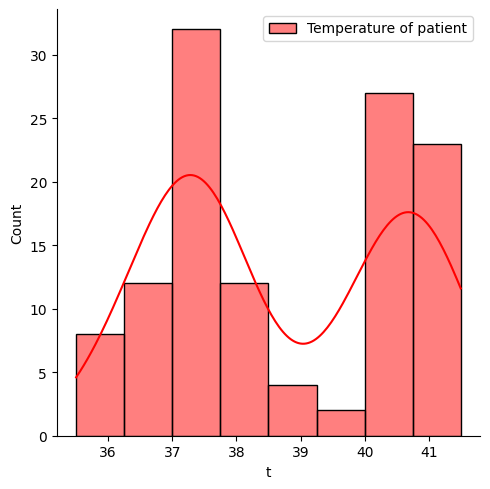

In [6]:
min_temp = min(X['t'])
max_temp = max(X['t'])
print(f"Min patient temperature = {min_temp}\nMax patient temperature = {max_temp}\n")

sns.displot(X['t'], color='red', label="Temperature of patient", kde=True)
plt.legend()
plt.show()

### Binarization of Temperature Data

We see that the temperature readings are mostly between either 37-37.5 degrees or 40-41.5 degrees.

**Threshold Selection:**

- **Threshold:** 38°C
- **Categorization:**
  - **High Temperature:** Temperatures > 38°C
  - **Low Temperature:** Temperatures ≤ 38°C

**Rationale:**

- **Source:** The threshold is based on the World Health Organization (WHO) definition of fever, which considers a temperature above 38°C as indicative of a fever. This provides a legitimate and widely accepted basis for the threshold.
- **Data Distribution:** The data shows a clear distinction around 38°C, with fewer samples around this point, making it a suitable cutoff.


**Conclusion:**

- The chosen threshold of 38°C effectively binarizes the temperature data into high and low categories, aligning with both medical standards and the data distribution.

**Reference:**

- [World Health Organization (WHO) Definition of Fever](https://www.who.int/health-topics/fever#tab=tab_1)

In [7]:
threshold = 38.0

# Create binary categories for temperature
X['t'] = np.where(X['t'] >= threshold, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't']]

Now Convert 'yes' and 'no' to True and False' for all the attributes and show the final binarized table:

In [8]:
# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

Let's now display the binarized attribute table.

In [9]:
s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])
X_att.head()

s1     s2     s3     s4     s5      t
case 0  False   True  False  False  False  False
case 1  False  False   True   True   True  False
case 2  False   True  False  False  False  False
case 3  False  False   True   True   True  False
case 4  False   True  False  False  False  False

Now convert 'yes' and 'no' to True and False.

In [10]:
y = y.replace(['yes', 'no'], [True, False])
y

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\4202387775.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


tar1   tar2
0    False  False
1     True  False
2    False  False
3     True  False
4    False  False
..     ...    ...
115  False   True
116  False  False
117  False   True
118  False   True
119  False   True

[120 rows x 2 columns]

In [11]:
binarized_data = X_bin.join(y["tar1"]).join(y["tar2"])
binarized_data

s1     s2     s3     s4     s5      t   tar1   tar2
0    False   True  False  False  False  False  False  False
1    False  False   True   True   True  False   True  False
2    False   True  False  False  False  False  False  False
3    False  False   True   True   True  False   True  False
4    False   True  False  False  False  False  False  False
..     ...    ...    ...    ...    ...    ...    ...    ...
115  False   True   True  False   True   True  False   True
116  False  False  False  False  False   True  False  False
117   True   True  False   True  False   True  False   True
118  False   True   True  False   True   True  False   True
119  False   True   True  False   True   True  False   True

[120 rows x 8 columns]

And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

s1     s2     s3     s4     s5      t
case 10   False  False   True   True   True  False
case 96   False   True   True  False   True   True
case 100  False   True   True  False   True   True
case 12   False   True  False  False  False  False
case 112   True   True  False   True  False   True
...         ...    ...    ...    ...    ...    ...
case 107  False  False  False  False  False   True
case 23   False  False   True   True   True  False
case 77   False   True   True  False   True   True
case 44   False  False   True  False  False  False
case 49   False  False   True   True  False  False

[96 rows x 6 columns]

In [13]:
y_train

tar1   tar2
10    True  False
96   False   True
100  False   True
12   False  False
112  False   True
..     ...    ...
107  False  False
23    True  False
77   False   True
44    True  False
49    True  False

[96 rows x 2 columns]

## Prediction quality measure

I prefer to use the F1 score because it maintains a balance between precision and recall for the classifier and it gives a better measure of the incorrectly classified cases than the accuracy metric.

## Fitting and testing the network on the task

### Finding the formal concepts

In [14]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 6 attributes, 277 connections)
        |s1|s2|s3|s4|s5|t|
case 10 |  |  | X| X| X| |
case 96 |  | X| X|  | X|X|
case 100|  | X| X|  | X|X|
case 12 |  | X|  |  |  | |
case 112| X| X|  | X|  |X|
case 43 |  |  | X|  |  | |
case 63 |  | X| X|  | X|X|
case 22 |  | X|  |  |  | |
case 62 |  | X| X|  | X|X|
case 24 |  |  | X| X| X| |
..........................
..........................
case 95 | X| X|  | X|  |X|
case 0  |  | X|  |  |  | |
case 57 |  | X|  |  |  | |
case 53 |  |  | X| X| X| |
case 79 | X| X| X| X| X|X|
case 107|  |  |  |  |  |X|
case 23 |  |  | X| X| X| |
case 77 |  | X| X|  | X|X|
case 44 |  |  | X|  |  | |
case 49 |  |  | X| X|  | |

In [15]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

20

So, we have 20 formal concepts. Let's compute F1 score for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

### Applying Neural FCA on target 1

In [16]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.27956989247311825
0.5544554455445545
0.2549019607843137
0.5185185185185185
0.23853211009174313
0.8256880733944955
0.6727272727272727
0.6324786324786325
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.72
0.5873015873015873
0.556390977443609
0.6716417910447762
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [17]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [18]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [19]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

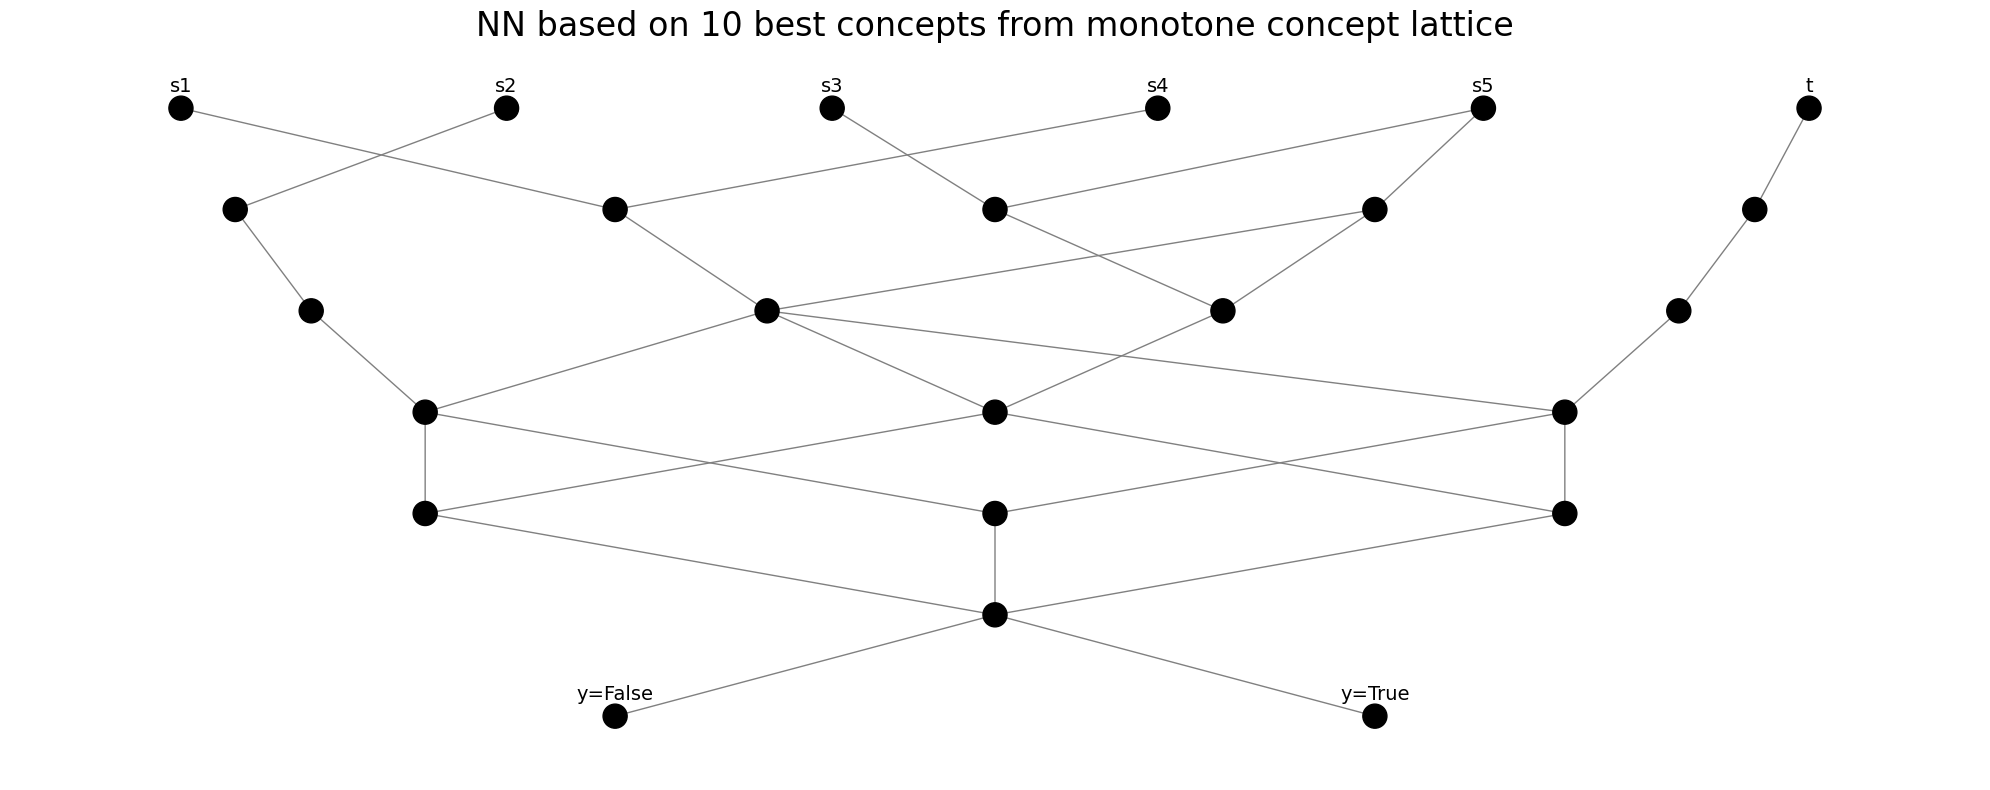

In [20]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [32]:
cn_1.fit(X_train, y_train['tar1'], n_epochs=500)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [ True False  True False  True False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


Now, let's check F1 score of our prediction

In [33]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 0.9333333333333333


Let's look at the fitted weights of edges.

C:\Users\Askeladd\AppData\Roaming\Python\Python39\site-packages\sparselinear\sparselinear.py:301: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:643.)
  weight = torch.sparse.FloatTensor(self.indices, self.weights, (self.out_features, self.in_features))


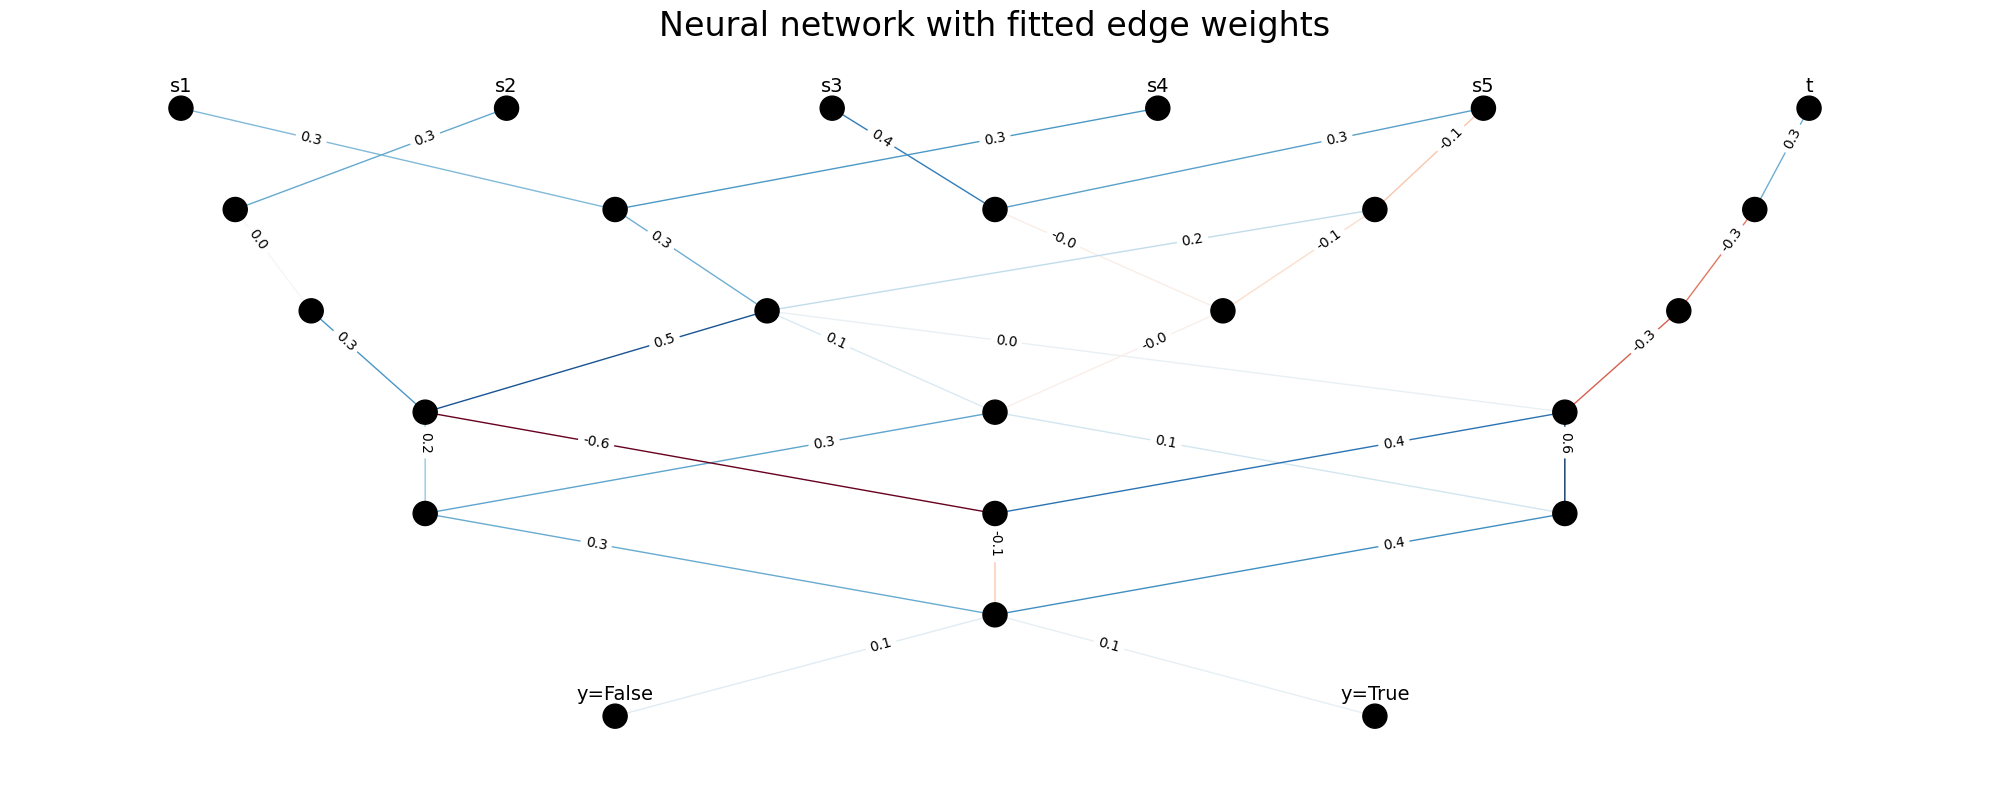

In [23]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Ok! We get normal result. Let's go further!

### Applying Neural FCA on target 2

In [24]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar2'], y_preds)
    print(c.measures['f1_score'])

0.0
0.6984126984126984
0.6172839506172839
0.5057471264367817
0.9213483146067416
0.845360824742268
0.8367346938775511
0.7884615384615384
0.780952380952381
0.6095238095238096
0.7735849056603774
0.7256637168141593
0.7256637168141593
0.7192982456140351
0.6833333333333333
0.6776859504132231
0.6721311475409836
0.6356589147286822
0.6307692307692307
0.5985401459854015


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [25]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [26]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [27]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

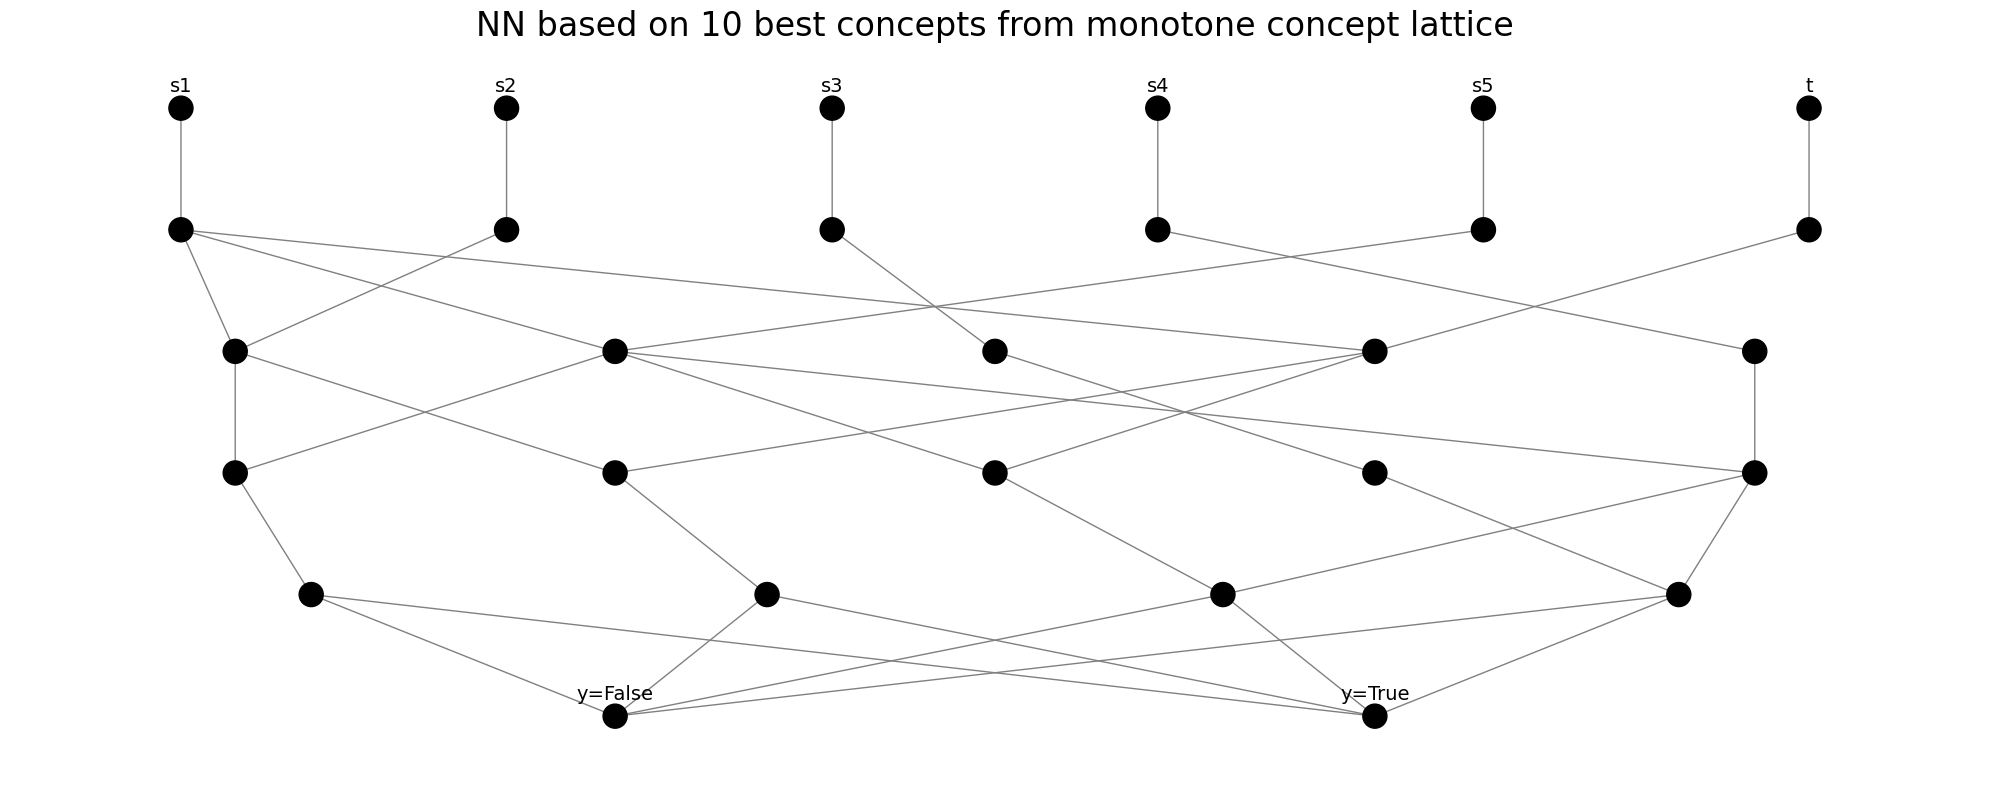

In [28]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [29]:
cn_2.fit(X_train, y_train['tar2'], n_epochs=5000)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [ True  True  True  True  True False  True  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


Now, let's check F1 score of our prediction

In [30]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 0.8571428571428571


Let's look at the fitted weights of edges.

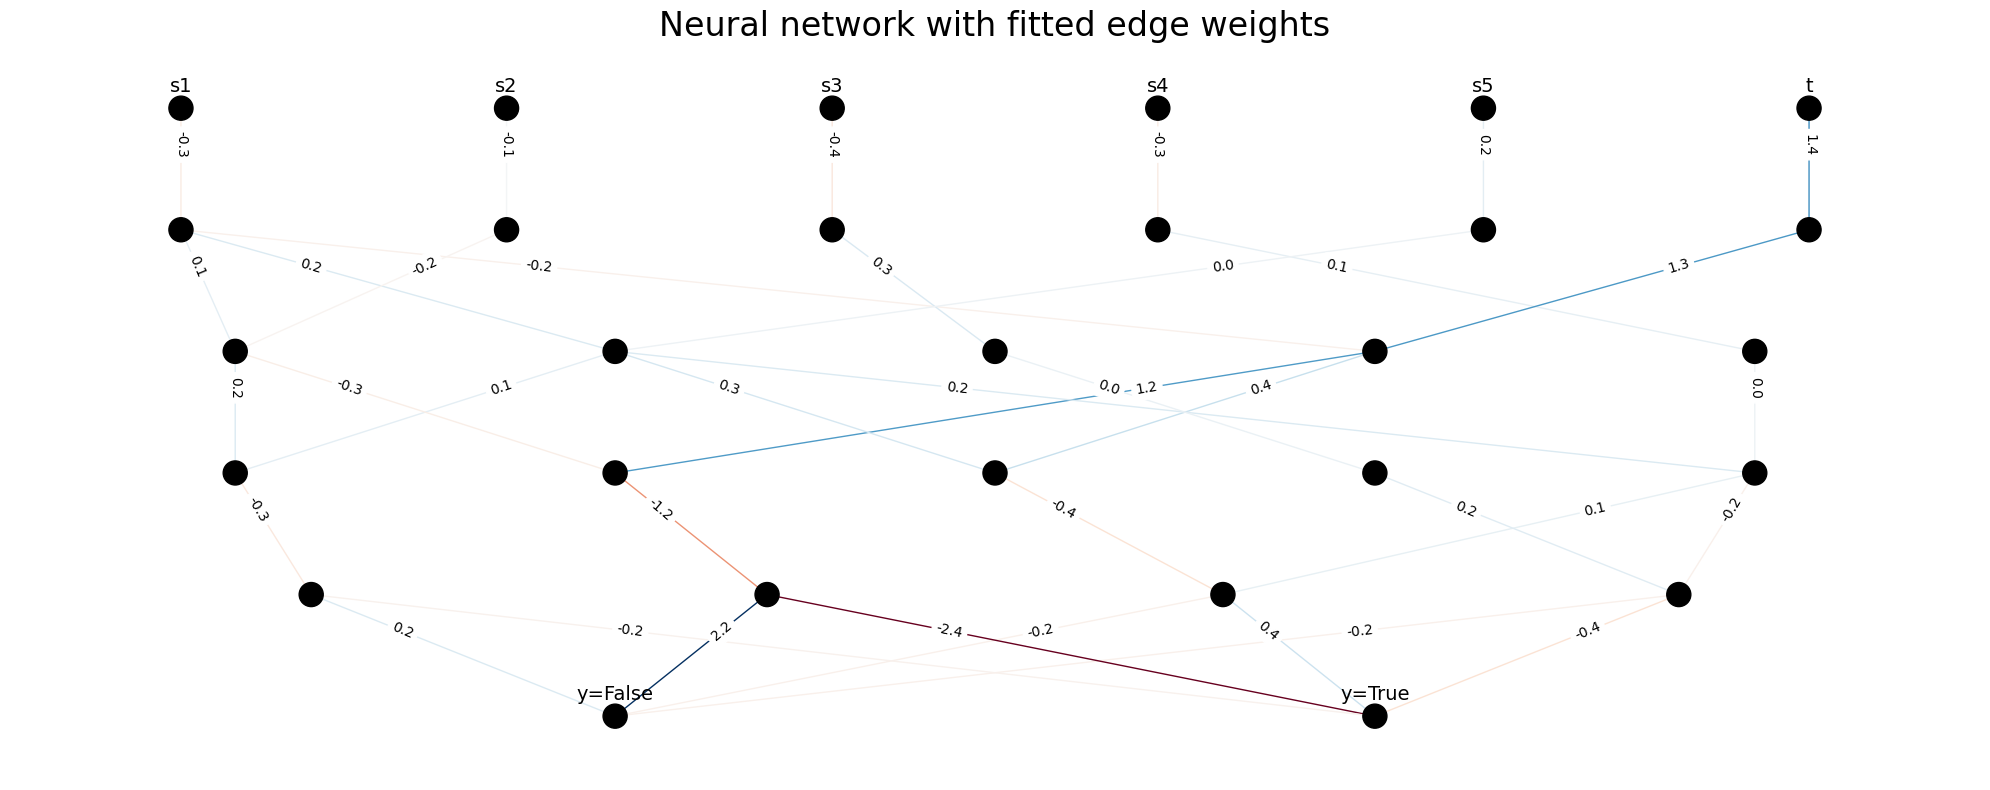

In [31]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

## Another attribute binarization of the original

### Fetch the data and binarize

*In* our data we have only one numerical attribute, so I am going to change its way of binarization. Now, let's divide it into 3 groups (based on the source [[2]](https://en.wikipedia.org/wiki/Human_body_temperature):
* temperature $\in[35.5,36.5]$;
* temperature $\in[35.5,37.5]$;
* temperature $\in[35.5,41.5]$.

In [34]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

threshold_1 = 35.5
threshold_2 = 36.5
threshold_3 = 37.5

# Create binary categories for temperature
X['t1'] = np.where(X['t'] >= threshold_1, 'yes', 'no')
X['t2'] = np.where(X['t'] >= threshold_2, 'yes', 'no')
X['t3'] = np.where(X['t'] >= threshold_3, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't1', 't2', 't3']]
X_cat


s1   s2   s3   s4   s5   t1   t2   t3
0     no  yes   no   no   no  yes   no   no
1     no   no  yes  yes  yes  yes   no   no
2     no  yes   no   no   no  yes   no   no
3     no   no  yes  yes  yes  yes   no   no
4     no  yes   no   no   no  yes   no   no
..   ...  ...  ...  ...  ...  ...  ...  ...
115   no  yes  yes   no  yes  yes  yes  yes
116   no   no   no   no   no  yes  yes  yes
117  yes  yes   no  yes   no  yes  yes  yes
118   no  yes  yes   no  yes  yes  yes  yes
119   no  yes  yes   no  yes  yes  yes  yes

[120 rows x 8 columns]

Convert 'yes' and 'no' to 'True' and 'False'

In [37]:
# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])
X_att

s1     s2     s3     s4     s5    t1     t2     t3
case 0    False   True  False  False  False  True  False  False
case 1    False  False   True   True   True  True  False  False
case 2    False   True  False  False  False  True  False  False
case 3    False  False   True   True   True  True  False  False
case 4    False   True  False  False  False  True  False  False
...         ...    ...    ...    ...    ...   ...    ...    ...
case 115  False   True   True  False   True  True   True   True
case 116  False  False  False  False  False  True   True   True
case 117   True   True  False   True  False  True   True   True
case 118  False   True   True  False   True  True   True   True
case 119  False   True   True  False   True  True   True   True

[120 rows x 8 columns]

Now do the same for target values

In [38]:
y = y.replace(['yes', 'no'], [True, False])
y

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\4202387775.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


tar1   tar2
0    False  False
1     True  False
2    False  False
3     True  False
4    False  False
..     ...    ...
115  False   True
116  False  False
117  False   True
118  False   True
119  False   True

[120 rows x 2 columns]

In [39]:
binarized_data = X_bin.join(y["tar1"]).join(y["tar2"])
binarized_data

s1     s2     s3     s4     s5    t1     t2     t3   tar1   tar2
0    False   True  False  False  False  True  False  False  False  False
1    False  False   True   True   True  True  False  False   True  False
2    False   True  False  False  False  True  False  False  False  False
3    False  False   True   True   True  True  False  False   True  False
4    False   True  False  False  False  True  False  False  False  False
..     ...    ...    ...    ...    ...   ...    ...    ...    ...    ...
115  False   True   True  False   True  True   True   True  False   True
116  False  False  False  False  False  True   True   True  False  False
117   True   True  False   True  False  True   True   True  False   True
118  False   True   True  False   True  True   True   True  False   True
119  False   True   True  False   True  True   True   True  False   True

[120 rows x 10 columns]

And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

s1     s2     s3     s4     s5    t1    t2     t3
case 10   False  False   True   True   True  True  True  False
case 96   False   True   True  False   True  True  True   True
case 100  False   True   True  False   True  True  True   True
case 12   False   True  False  False  False  True  True  False
case 112   True   True  False   True  False  True  True   True
...         ...    ...    ...    ...    ...   ...   ...    ...
case 107  False  False  False  False  False  True  True   True
case 23   False  False   True   True   True  True  True  False
case 77   False   True   True  False   True  True  True   True
case 44   False  False   True  False  False  True  True   True
case 49   False  False   True   True  False  True  True   True

[96 rows x 8 columns]

### Finding the Concept Lattice

In [41]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 8 attributes, 481 connections)
        |s1|s2|s3|s4|s5|t1|t2|t3|
case 10 |  |  | X| X| X| X| X|  |
case 96 |  | X| X|  | X| X| X| X|
case 100|  | X| X|  | X| X| X| X|
case 12 |  | X|  |  |  | X| X|  |
case 112| X| X|  | X|  | X| X| X|
case 43 |  |  | X|  |  | X| X| X|
case 63 |  | X| X|  | X| X| X| X|
case 22 |  | X|  |  |  | X| X|  |
case 62 |  | X| X|  | X| X| X| X|
case 24 |  |  | X| X| X| X| X|  |
.................................
.................................
case 95 | X| X|  | X|  | X| X| X|
case 0  |  | X|  |  |  | X|  |  |
case 57 |  | X|  |  |  | X| X| X|
case 53 |  |  | X| X| X| X| X| X|
case 79 | X| X| X| X| X| X| X| X|
case 107|  |  |  |  |  | X| X| X|
case 23 |  |  | X| X| X| X| X|  |
case 77 |  | X| X|  | X| X| X| X|
case 44 |  |  | X|  |  | X| X| X|
case 49 |  |  | X| X|  | X| X| X|

In [42]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

23

So, we have 23 formal concepts. Let's compute F1 score for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

### Applying Neural FCA on target 1

In [43]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.5544554455445545
0.2549019607843137
0.8256880733944955
0.6727272727272727
0.49557522123893805
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.64
0.5873015873015873
0.6614173228346457
0.6923076923076923
0.631578947368421
0.6716417910447762
0.5882352941176471
0.6617647058823529
0.6086956521739131
0.6086956521739131
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 15 concepts as they gave the best F1 score.

In [44]:
concepts_count = 15
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [45]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [46]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

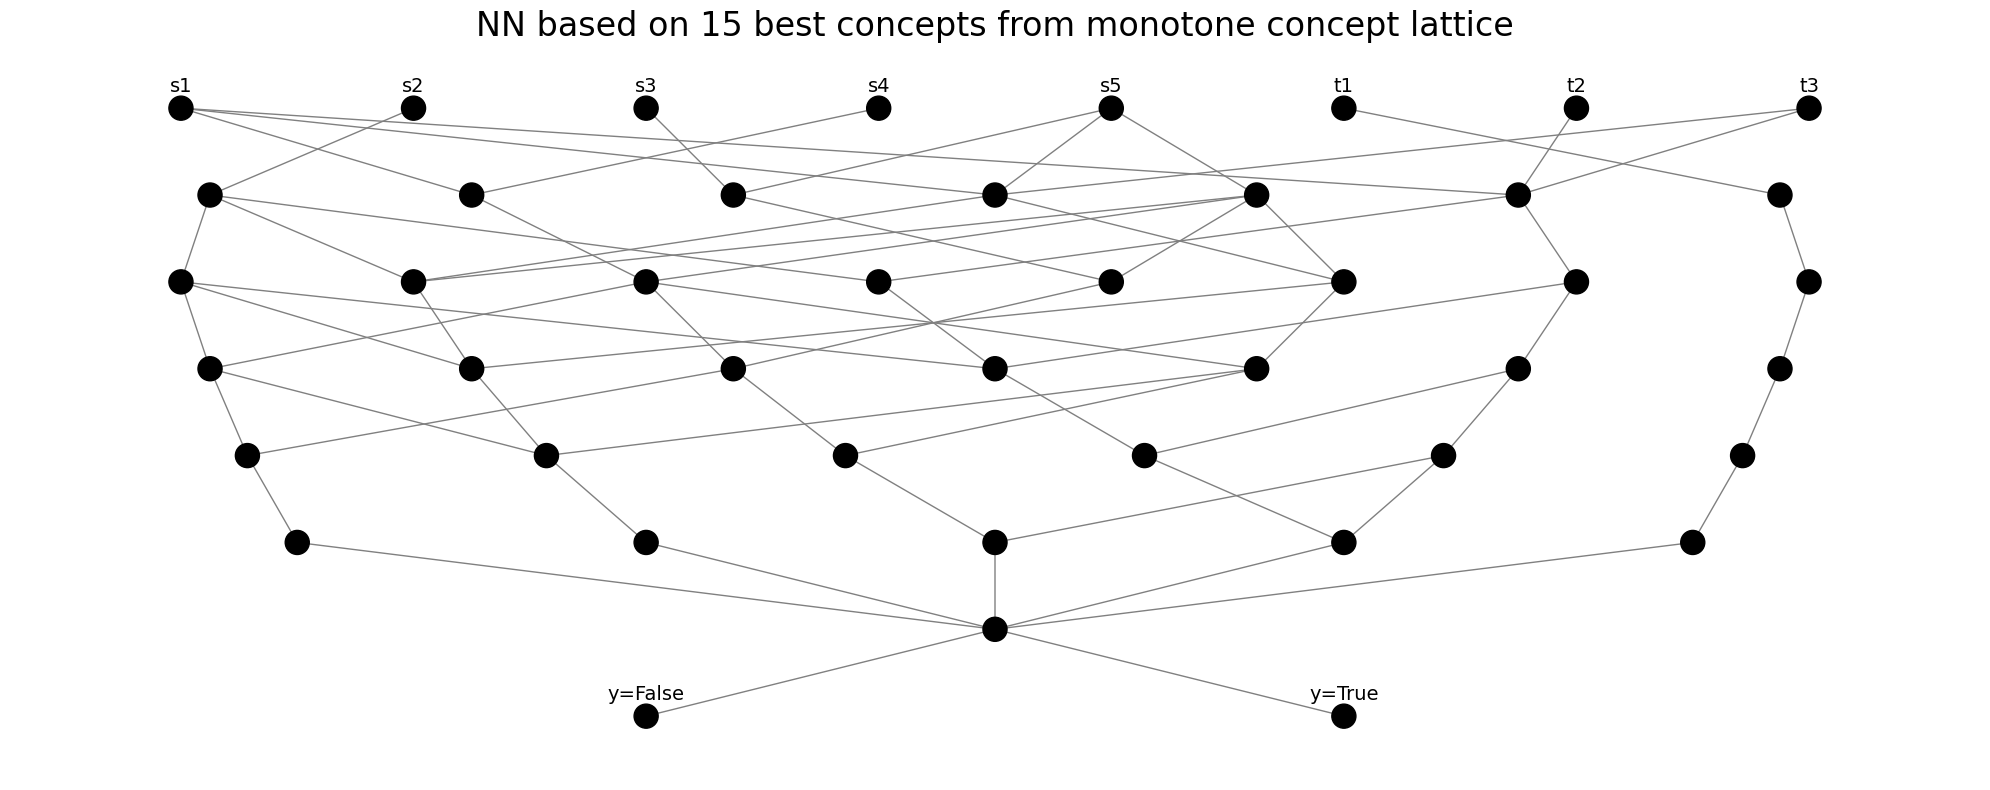

In [47]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [54]:
cn_1.fit(X_train, y_train['tar1'], n_epochs=500)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False  True  True  True False False  True False  True False  True  True
 False  True False  True  True  True  True  True False  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


In [55]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 0.7857142857142857


Let's look at the fitted weights of edges.

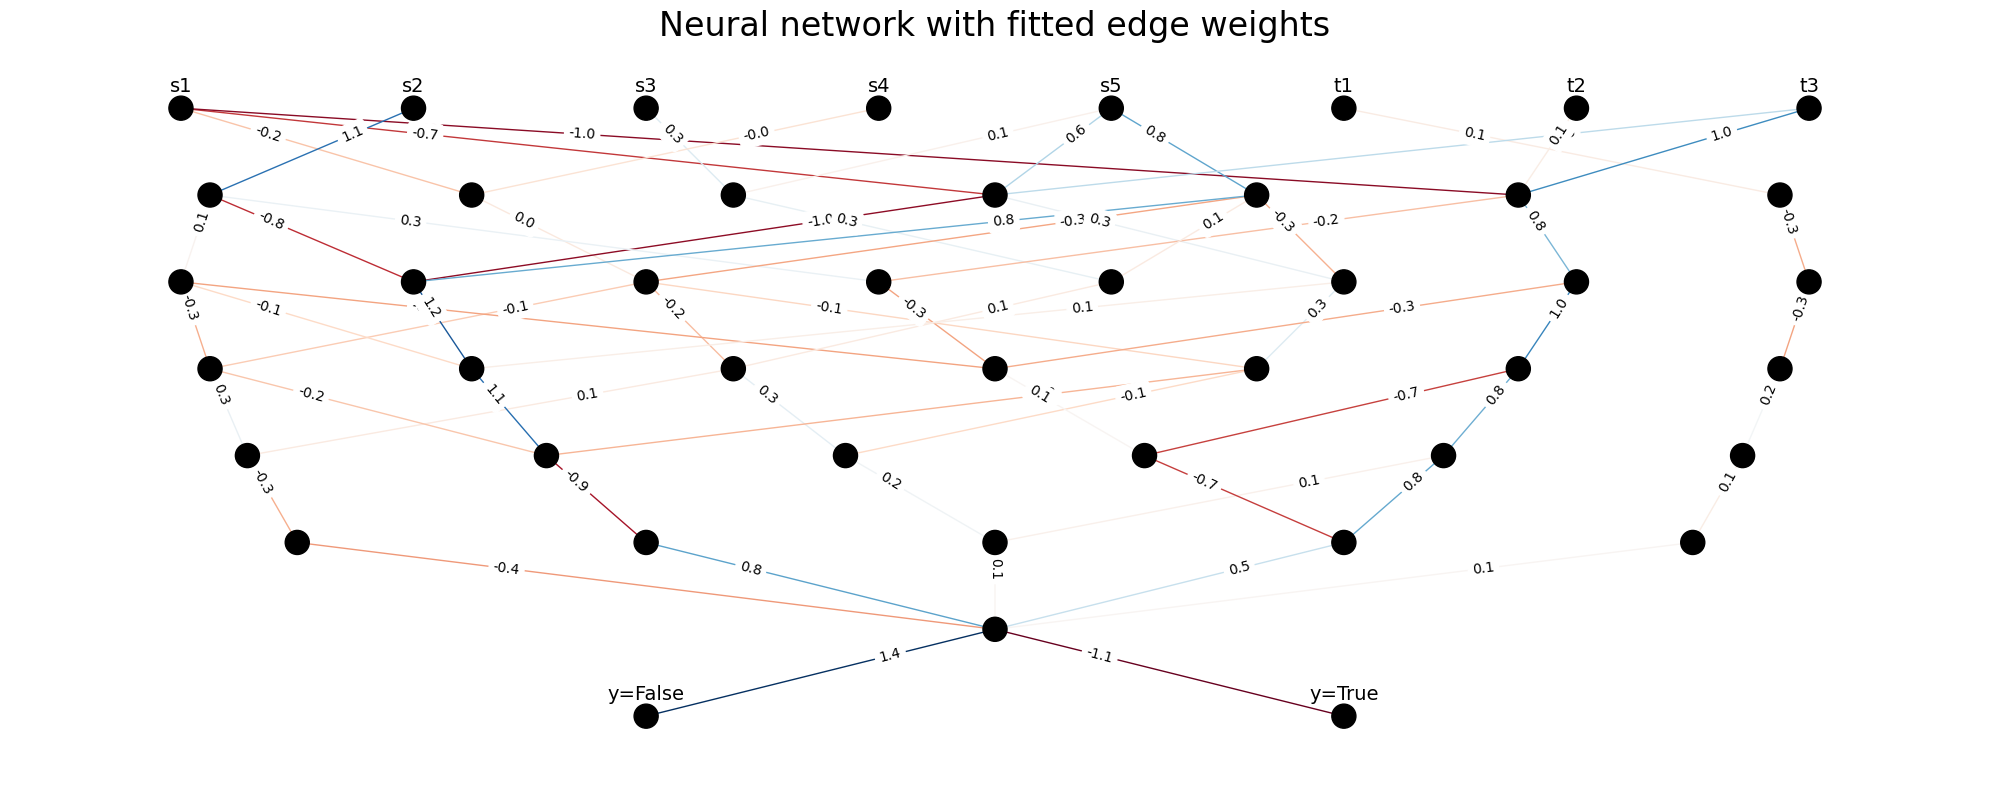

In [56]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

### Applying Neural FCA on target 2

In [57]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar2'], y_preds)
    print(c.measures['f1_score'])

0.0
0.6984126984126984
0.6172839506172839
0.5057471264367817
0.845360824742268
0.8367346938775511
0.6095238095238096
0.7735849056603774
0.7522935779816514
0.7256637168141593
0.7192982456140351
0.6833333333333333
0.6776859504132231
0.6721311475409836
0.6666666666666666
0.6507936507936508
0.6356589147286822
0.6307692307692307
0.6212121212121212
0.6212121212121212
0.6119402985074627
0.6119402985074627
0.5985401459854015


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [58]:
concepts_count = 15
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [59]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [60]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

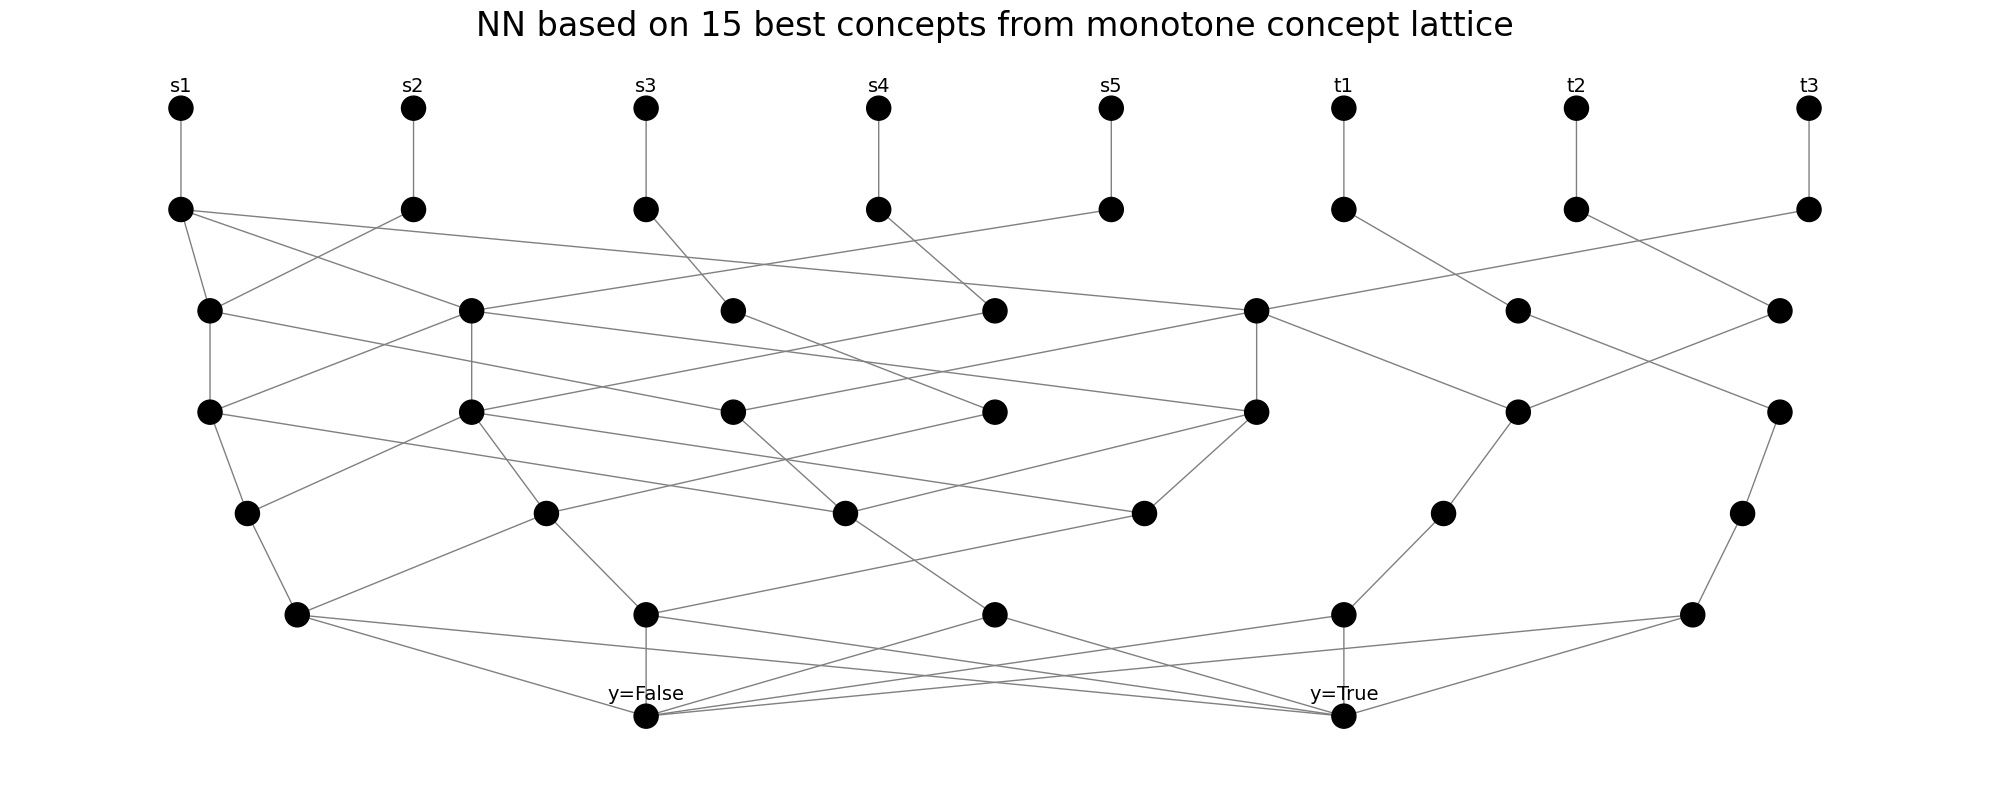

In [61]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [65]:
cn_2.fit(X_train, y_train['tar2'], n_epochs=500)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [False False  True False False False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


In [66]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 0.875


Let's look at the fitted weights of edges.

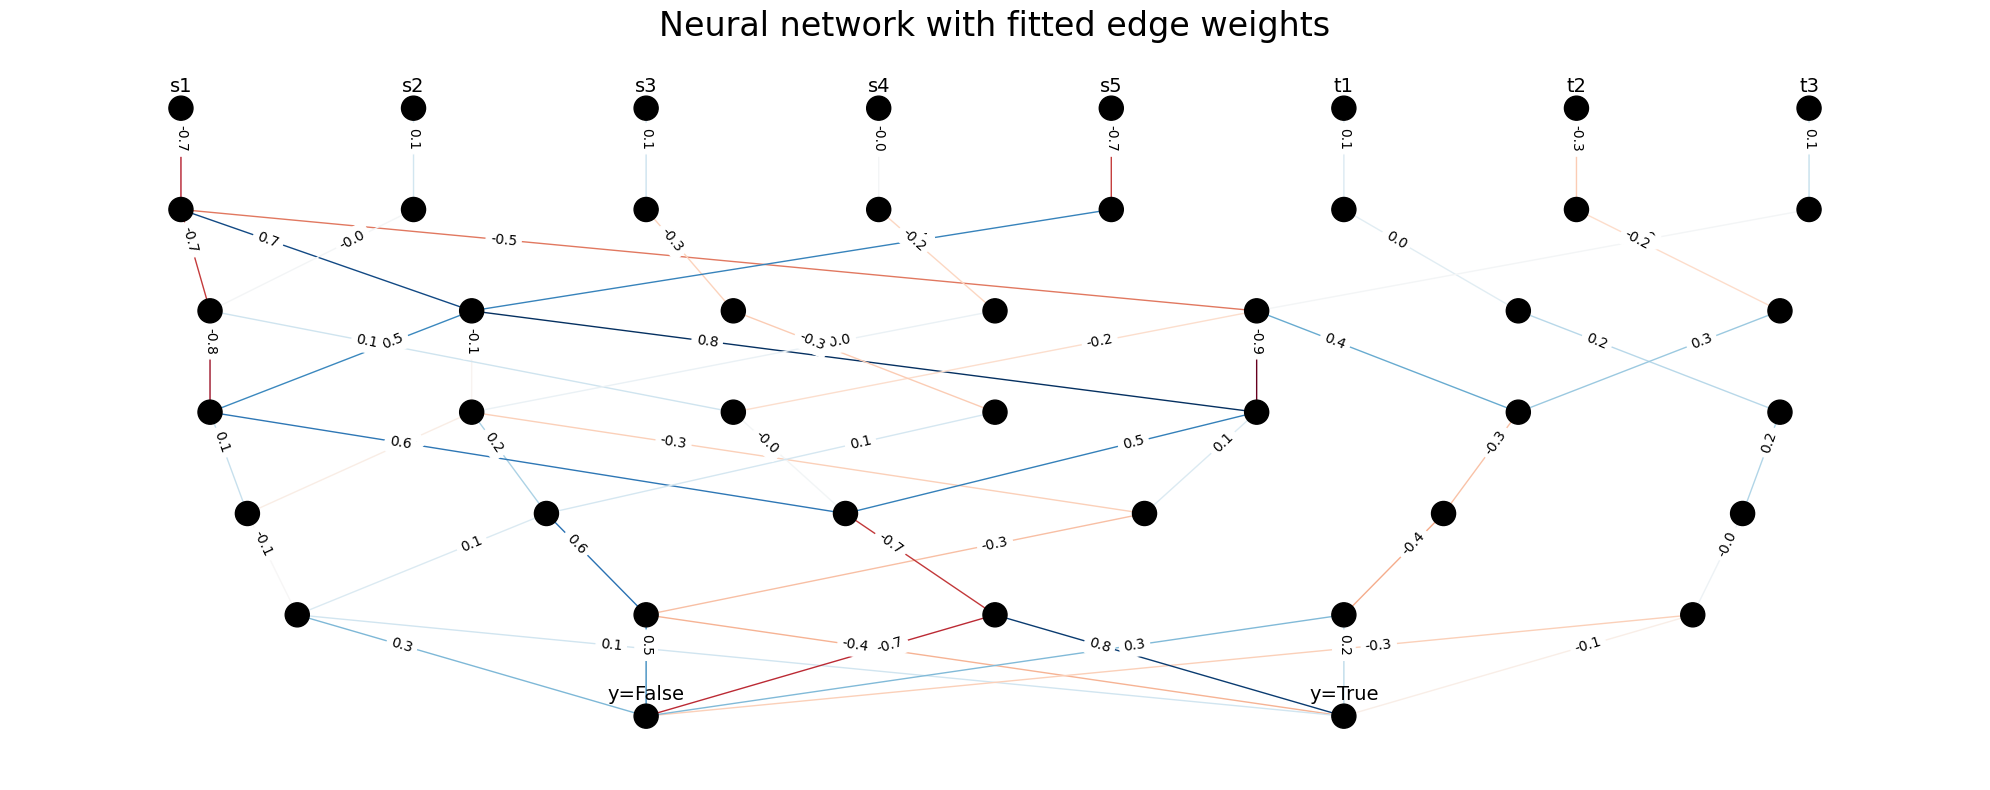

In [67]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

### We got worse results using the second binarization technique.

## Now lets use another technique to select best concepts from the concept lattice on first binarized dataset.

### Fetch and binarize the dataset

In [ ]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

threshold = 38

# Create binary categories for temperature
X['t'] = np.where(X['t'] >= threshold, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't']]
X_cat


s1   s2   s3   s4   s5    t
0     no  yes   no   no   no   no
1     no   no  yes  yes  yes   no
2     no  yes   no   no   no   no
3     no   no  yes  yes  yes   no
4     no  yes   no   no   no   no
..   ...  ...  ...  ...  ...  ...
115   no  yes  yes   no  yes  yes
116   no   no   no   no   no  yes
117  yes  yes   no  yes   no  yes
118   no  yes  yes   no  yes  yes
119   no  yes  yes   no  yes  yes

[120 rows x 6 columns]

Convert 'yes' and 'no' to 'True' and 'False'

In [ ]:
# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])
X_att

s1     s2     s3     s4     s5      t
case 0    False   True  False  False  False  False
case 1    False  False   True   True   True  False
case 2    False   True  False  False  False  False
case 3    False  False   True   True   True  False
case 4    False   True  False  False  False  False
...         ...    ...    ...    ...    ...    ...
case 115  False   True   True  False   True   True
case 116  False  False  False  False  False   True
case 117   True   True  False   True  False   True
case 118  False   True   True  False   True   True
case 119  False   True   True  False   True   True

[120 rows x 6 columns]

Now do the same for target values

In [112]:
y = y.replace(['yes', 'no'], [True, False])
y

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\4202387775.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


tar1   tar2
0    False  False
1     True  False
2    False  False
3     True  False
4    False  False
..     ...    ...
115  False   True
116  False  False
117  False   True
118  False   True
119  False   True

[120 rows x 2 columns]

In [113]:
binarized_data = X_bin.join(y["tar1"]).join(y["tar2"])
binarized_data

s1     s2     s3     s4     s5      t   tar1   tar2
0    False   True  False  False  False  False  False  False
1    False  False   True   True   True  False   True  False
2    False   True  False  False  False  False  False  False
3    False  False   True   True   True  False   True  False
4    False   True  False  False  False  False  False  False
..     ...    ...    ...    ...    ...    ...    ...    ...
115  False   True   True  False   True   True  False   True
116  False  False  False  False  False   True  False  False
117   True   True  False   True  False   True  False   True
118  False   True   True  False   True   True  False   True
119  False   True   True  False   True   True  False   True

[120 rows x 8 columns]

And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

s1     s2     s3     s4     s5      t
case 10   False  False   True   True   True  False
case 96   False   True   True  False   True   True
case 100  False   True   True  False   True   True
case 12   False   True  False  False  False  False
case 112   True   True  False   True  False   True
...         ...    ...    ...    ...    ...    ...
case 107  False  False  False  False  False   True
case 23   False  False   True   True   True  False
case 77   False   True   True  False   True   True
case 44   False  False   True  False  False  False
case 49   False  False   True   True  False  False

[96 rows x 6 columns]

### Fitting and testing the network on the task

Firstly, let's put binarized data in Formal Context and compute monotone Concept Lattice.


In [115]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 6 attributes, 277 connections)
        |s1|s2|s3|s4|s5|t|
case 10 |  |  | X| X| X| |
case 96 |  | X| X|  | X|X|
case 100|  | X| X|  | X|X|
case 12 |  | X|  |  |  | |
case 112| X| X|  | X|  |X|
case 43 |  |  | X|  |  | |
case 63 |  | X| X|  | X|X|
case 22 |  | X|  |  |  | |
case 62 |  | X| X|  | X|X|
case 24 |  |  | X| X| X| |
..........................
..........................
case 95 | X| X|  | X|  |X|
case 0  |  | X|  |  |  | |
case 57 |  | X|  |  |  | |
case 53 |  |  | X| X| X| |
case 79 | X| X| X| X| X|X|
case 107|  |  |  |  |  |X|
case 23 |  |  | X| X| X| |
case 77 |  | X| X|  | X|X|
case 44 |  |  | X|  |  | |
case 49 |  |  | X| X|  | |

In [ ]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

20

So, we have 20 formal concepts. Let's compute accuracy for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

### Applying Neural FCA on target 1

In [117]:
from sklearn.metrics import accuracy_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['accuracy'] = accuracy_score(y_train['tar1'], y_preds)
    print(c.measures['accuracy'])

0.53125
0.5729166666666666
0.5520833333333334
0.8229166666666666
0.3020833333333333
0.53125
0.20833333333333334
0.4583333333333333
0.13541666666666666
0.8020833333333334
0.625
0.5520833333333334
0.3645833333333333
0.7083333333333334
0.2916666666666667
0.6354166666666666
0.4583333333333333
0.3854166666666667
0.5416666666666666
0.46875


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best accuracy.

In [118]:
concepts_count = 10
best_concepts = list(L.measures['accuracy'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [119]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [120]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

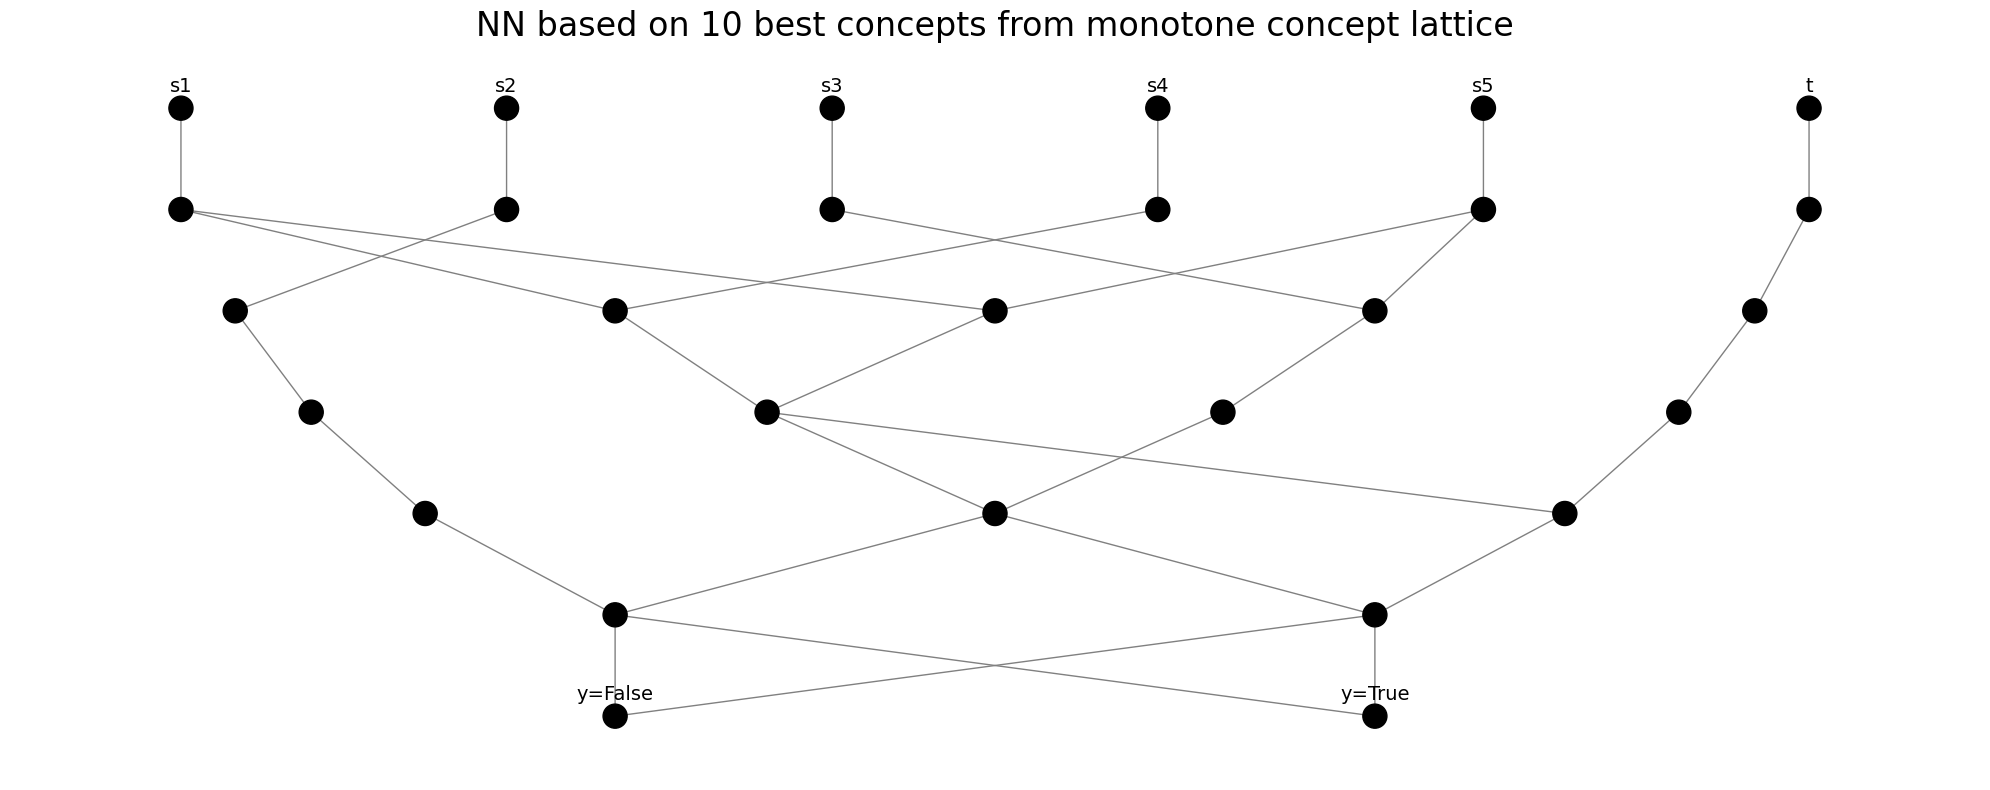

In [121]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [126]:
cn_1.fit(X_train, y_train['tar1'], n_epochs=500)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False  True False False False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


Now, let's check F1 score of our prediction

In [127]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 0.5714285714285714


Let's look at the fitted weights of edges.

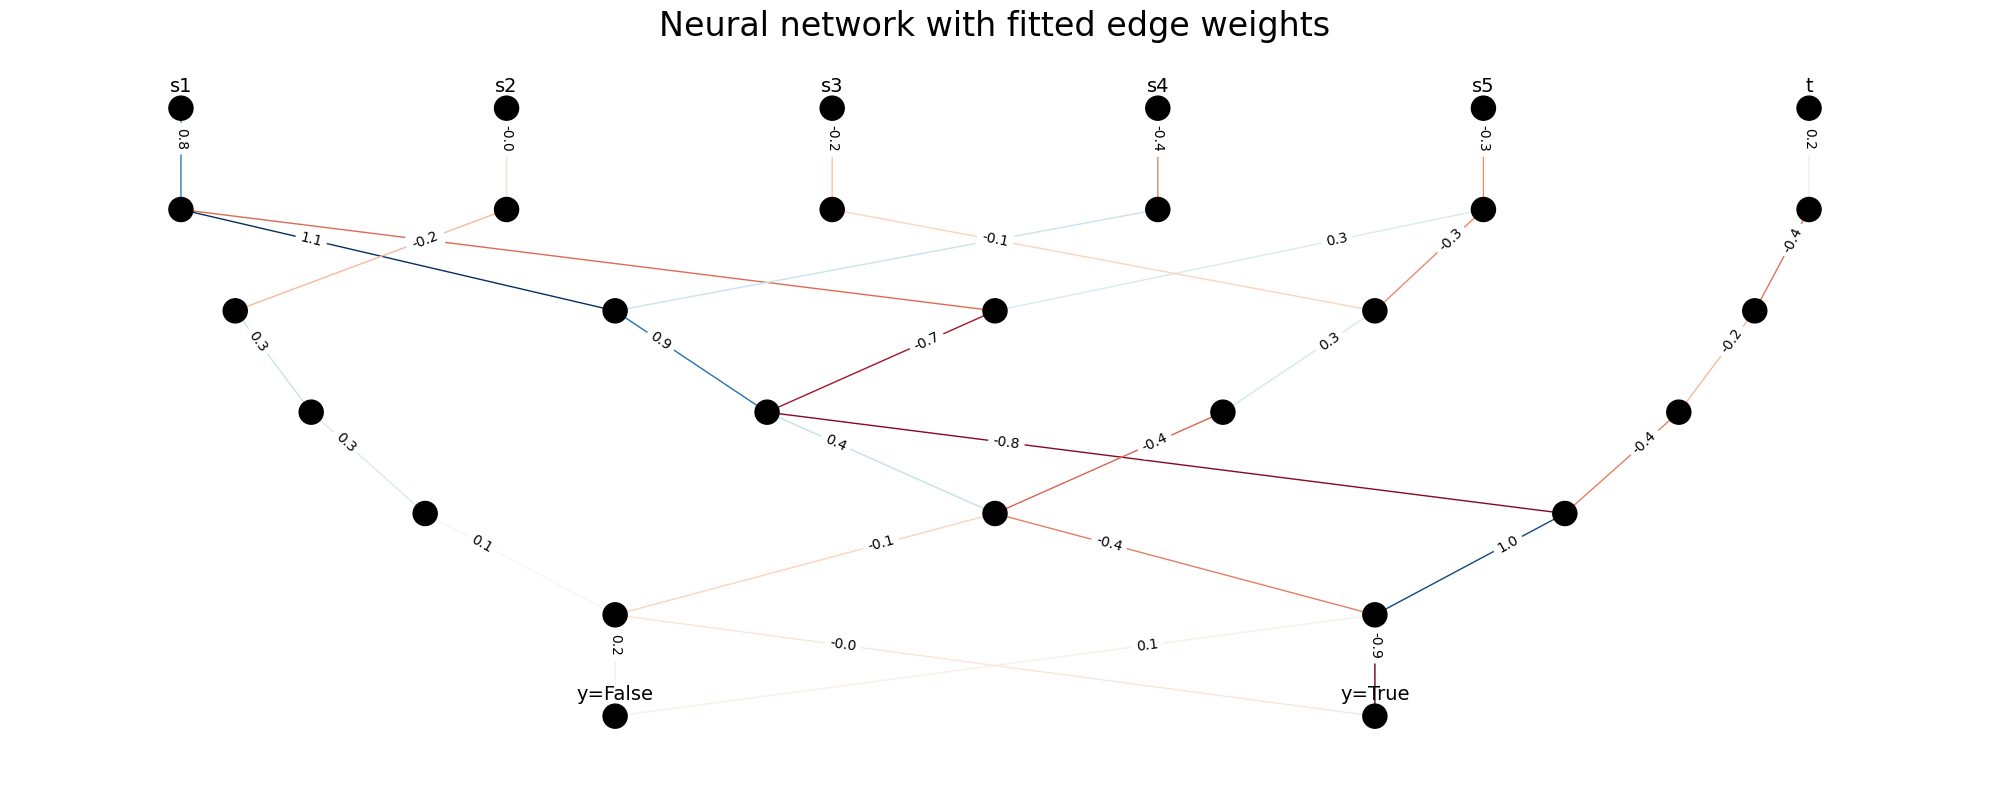

In [128]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Ok! We get very bad result. Let's go further!

### Applying Neural FCA on target 2

In [135]:
from sklearn.metrics import accuracy_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['accuracy'] = accuracy_score(y_train['tar2'], y_preds)
    print(c.measures['accuracy'])

0.5729166666666666
0.8020833333333334
0.6770833333333334
0.5520833333333334
0.9270833333333334
0.84375
0.8333333333333334
0.7708333333333334
0.7604166666666666
0.5729166666666666
0.75
0.6770833333333334
0.6770833333333334
0.6666666666666666
0.6041666666666666
0.59375
0.5833333333333334
0.5104166666666666
0.5
0.4270833333333333


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [136]:
concepts_count = 12
best_concepts = list(L.measures['accuracy'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [137]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [138]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

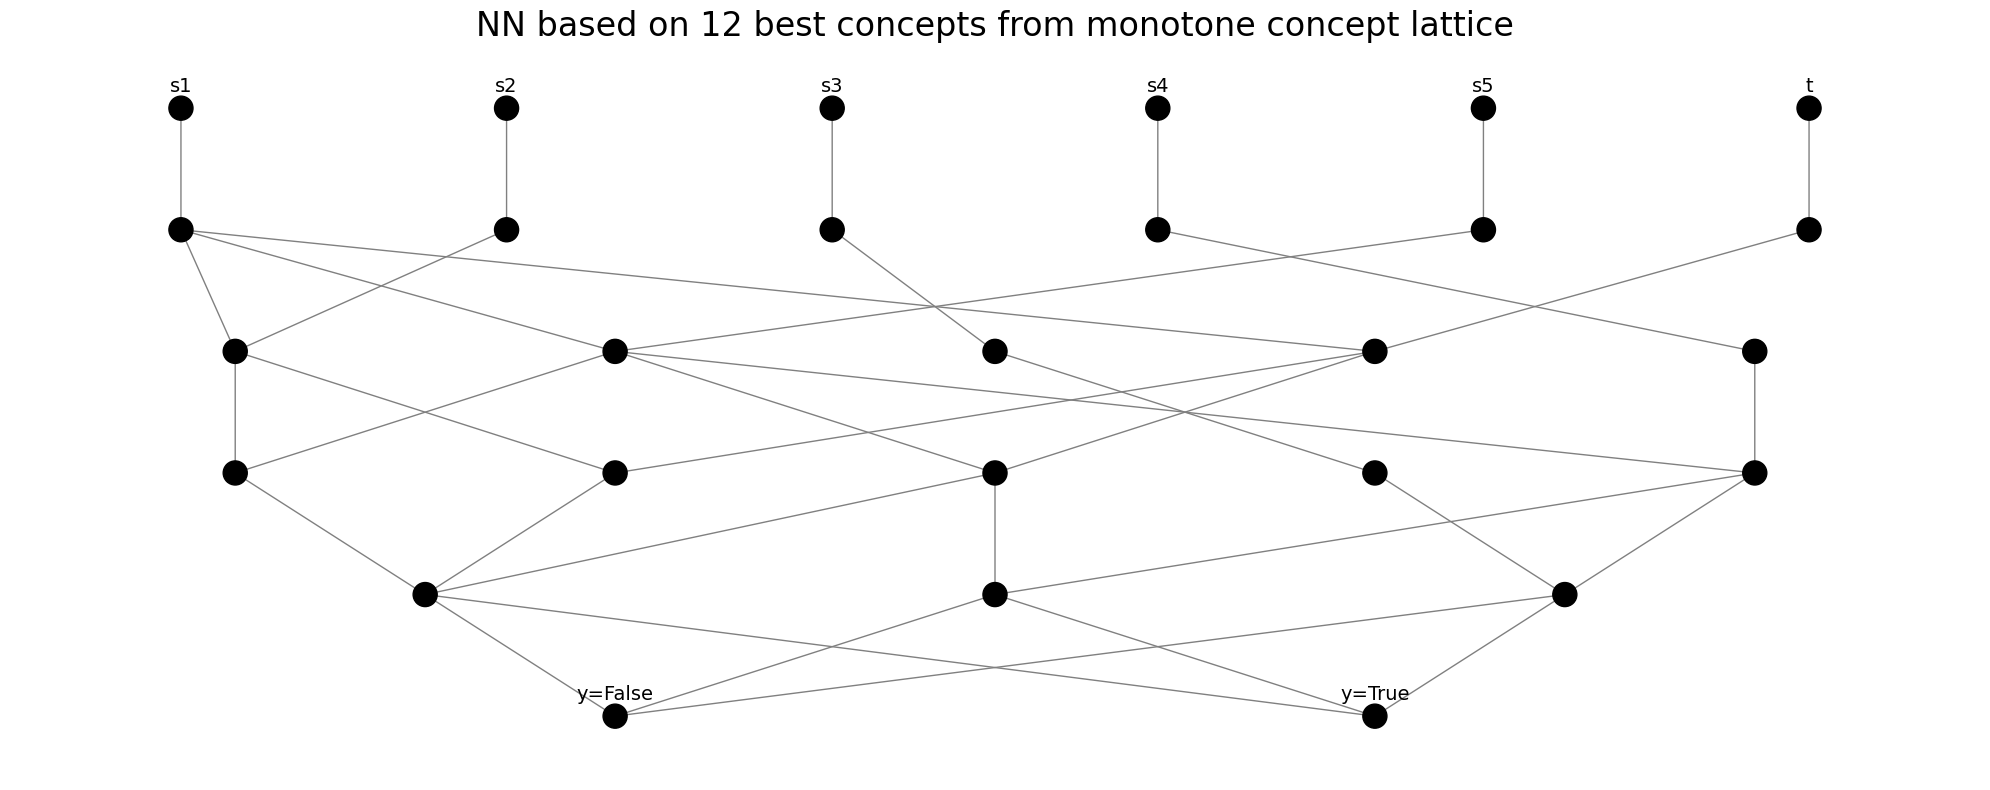

In [139]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [146]:
cn_2.fit(X_train, y_train['tar2'], n_epochs=500)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [False False  True False False False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


Now, let's check F1 score of our prediction

In [147]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 0.875


Let's look at the fitted weights of edges.

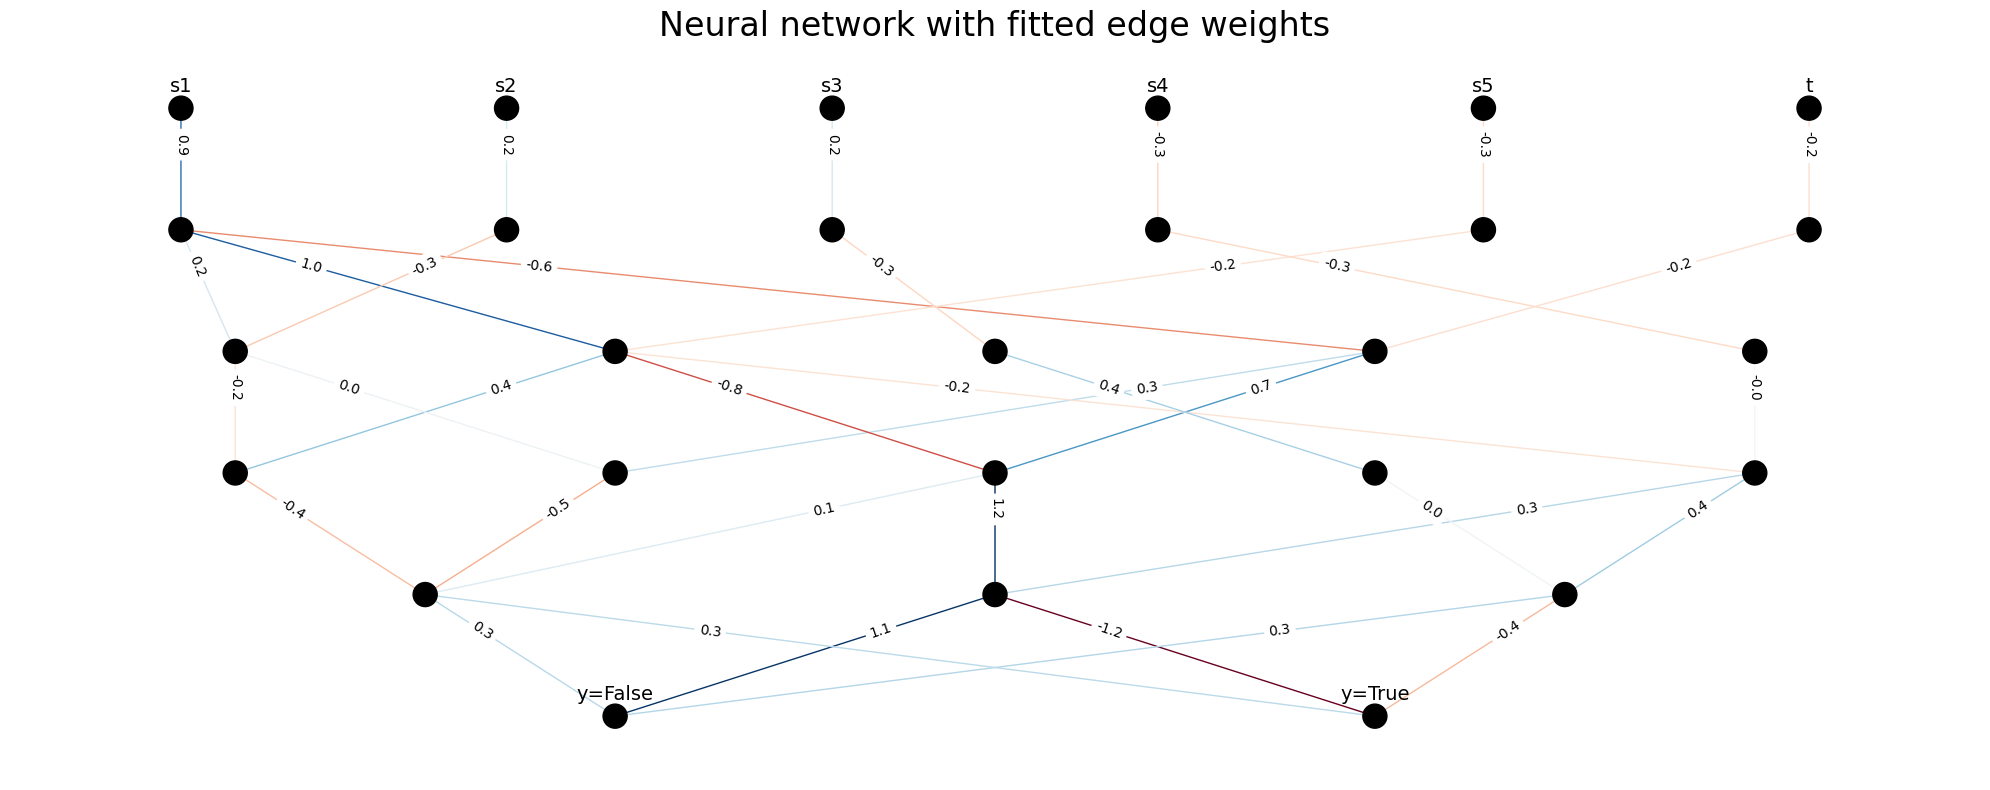

In [148]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Ok! We get very bad result. Our first approach was the best.

## Now lets use this technique to select best concepts from the concept lattice on second binarized dataset.

### Fetch and binarize the dataset

In [172]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

threshold_1 = 35.5
threshold_2 = 36.5
threshold_3 = 37.5

# Create binary categories for temperature
X['t1'] = np.where(X['t'] >= threshold_1, 'yes', 'no')
X['t2'] = np.where(X['t'] >= threshold_2, 'yes', 'no')
X['t3'] = np.where(X['t'] >= threshold_3, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't1', 't2', 't3']]
X_cat


s1   s2   s3   s4   s5   t1   t2   t3
0     no  yes   no   no   no  yes   no   no
1     no   no  yes  yes  yes  yes   no   no
2     no  yes   no   no   no  yes   no   no
3     no   no  yes  yes  yes  yes   no   no
4     no  yes   no   no   no  yes   no   no
..   ...  ...  ...  ...  ...  ...  ...  ...
115   no  yes  yes   no  yes  yes  yes  yes
116   no   no   no   no   no  yes  yes  yes
117  yes  yes   no  yes   no  yes  yes  yes
118   no  yes  yes   no  yes  yes  yes  yes
119   no  yes  yes   no  yes  yes  yes  yes

[120 rows x 8 columns]

Convert 'yes' and 'no' to 'True' and 'False'

In [173]:
# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])
X_att

s1     s2     s3     s4     s5    t1     t2     t3
case 0    False   True  False  False  False  True  False  False
case 1    False  False   True   True   True  True  False  False
case 2    False   True  False  False  False  True  False  False
case 3    False  False   True   True   True  True  False  False
case 4    False   True  False  False  False  True  False  False
...         ...    ...    ...    ...    ...   ...    ...    ...
case 115  False   True   True  False   True  True   True   True
case 116  False  False  False  False  False  True   True   True
case 117   True   True  False   True  False  True   True   True
case 118  False   True   True  False   True  True   True   True
case 119  False   True   True  False   True  True   True   True

[120 rows x 8 columns]

Now do the same for target values

In [174]:
y = y.replace(['yes', 'no'], [True, False])
y

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\4202387775.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


tar1   tar2
0    False  False
1     True  False
2    False  False
3     True  False
4    False  False
..     ...    ...
115  False   True
116  False  False
117  False   True
118  False   True
119  False   True

[120 rows x 2 columns]

In [175]:
binarized_data = X_bin.join(y["tar1"]).join(y["tar2"])
binarized_data

s1     s2     s3     s4     s5    t1     t2     t3   tar1   tar2
0    False   True  False  False  False  True  False  False  False  False
1    False  False   True   True   True  True  False  False   True  False
2    False   True  False  False  False  True  False  False  False  False
3    False  False   True   True   True  True  False  False   True  False
4    False   True  False  False  False  True  False  False  False  False
..     ...    ...    ...    ...    ...   ...    ...    ...    ...    ...
115  False   True   True  False   True  True   True   True  False   True
116  False  False  False  False  False  True   True   True  False  False
117   True   True  False   True  False  True   True   True  False   True
118  False   True   True  False   True  True   True   True  False   True
119  False   True   True  False   True  True   True   True  False   True

[120 rows x 10 columns]

And finally, let's split the data into train and test ones in ratio 80% to 20 % (the most common ratio).

In [176]:
X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

s1     s2     s3     s4     s5    t1    t2     t3
case 10   False  False   True   True   True  True  True  False
case 96   False   True   True  False   True  True  True   True
case 100  False   True   True  False   True  True  True   True
case 12   False   True  False  False  False  True  True  False
case 112   True   True  False   True  False  True  True   True
...         ...    ...    ...    ...    ...   ...   ...    ...
case 107  False  False  False  False  False  True  True   True
case 23   False  False   True   True   True  True  True  False
case 77   False   True   True  False   True  True  True   True
case 44   False  False   True  False  False  True  True   True
case 49   False  False   True   True  False  True  True   True

[96 rows x 8 columns]

### Fitting and testing the network on the task

Firstly, let's put binarized data in Formal Context and compute monotone Concept Lattice.


In [177]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 8 attributes, 481 connections)
        |s1|s2|s3|s4|s5|t1|t2|t3|
case 10 |  |  | X| X| X| X| X|  |
case 96 |  | X| X|  | X| X| X| X|
case 100|  | X| X|  | X| X| X| X|
case 12 |  | X|  |  |  | X| X|  |
case 112| X| X|  | X|  | X| X| X|
case 43 |  |  | X|  |  | X| X| X|
case 63 |  | X| X|  | X| X| X| X|
case 22 |  | X|  |  |  | X| X|  |
case 62 |  | X| X|  | X| X| X| X|
case 24 |  |  | X| X| X| X| X|  |
.................................
.................................
case 95 | X| X|  | X|  | X| X| X|
case 0  |  | X|  |  |  | X|  |  |
case 57 |  | X|  |  |  | X| X| X|
case 53 |  |  | X| X| X| X| X| X|
case 79 | X| X| X| X| X| X| X| X|
case 107|  |  |  |  |  | X| X| X|
case 23 |  |  | X| X| X| X| X|  |
case 77 |  | X| X|  | X| X| X| X|
case 44 |  |  | X|  |  | X| X| X|
case 49 |  |  | X| X|  | X| X| X|

In [178]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

23

So, we have 20 formal concepts. Let's compute F1 score for each formal concept (assuming that an object is predicted True if it is in the extent of the concept).

### Applying Neural FCA on target 1

In [179]:
from sklearn.metrics import accuracy_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['accuracy'] = accuracy_score(y_train['tar1'], y_preds)
    print(c.measures['accuracy'])

0.53125
0.5729166666666666
0.5520833333333334
0.8229166666666666
0.53125
0.20833333333333334
0.8020833333333334
0.625
0.40625
0.3645833333333333
0.7083333333333334
0.2916666666666667
0.53125
0.4583333333333333
0.5520833333333334
0.5833333333333334
0.4895833333333333
0.5416666666666666
0.4166666666666667
0.5208333333333334
0.4375
0.4375
0.46875


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [180]:
concepts_count = 10
best_concepts = list(L.measures['accuracy'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [181]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [182]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

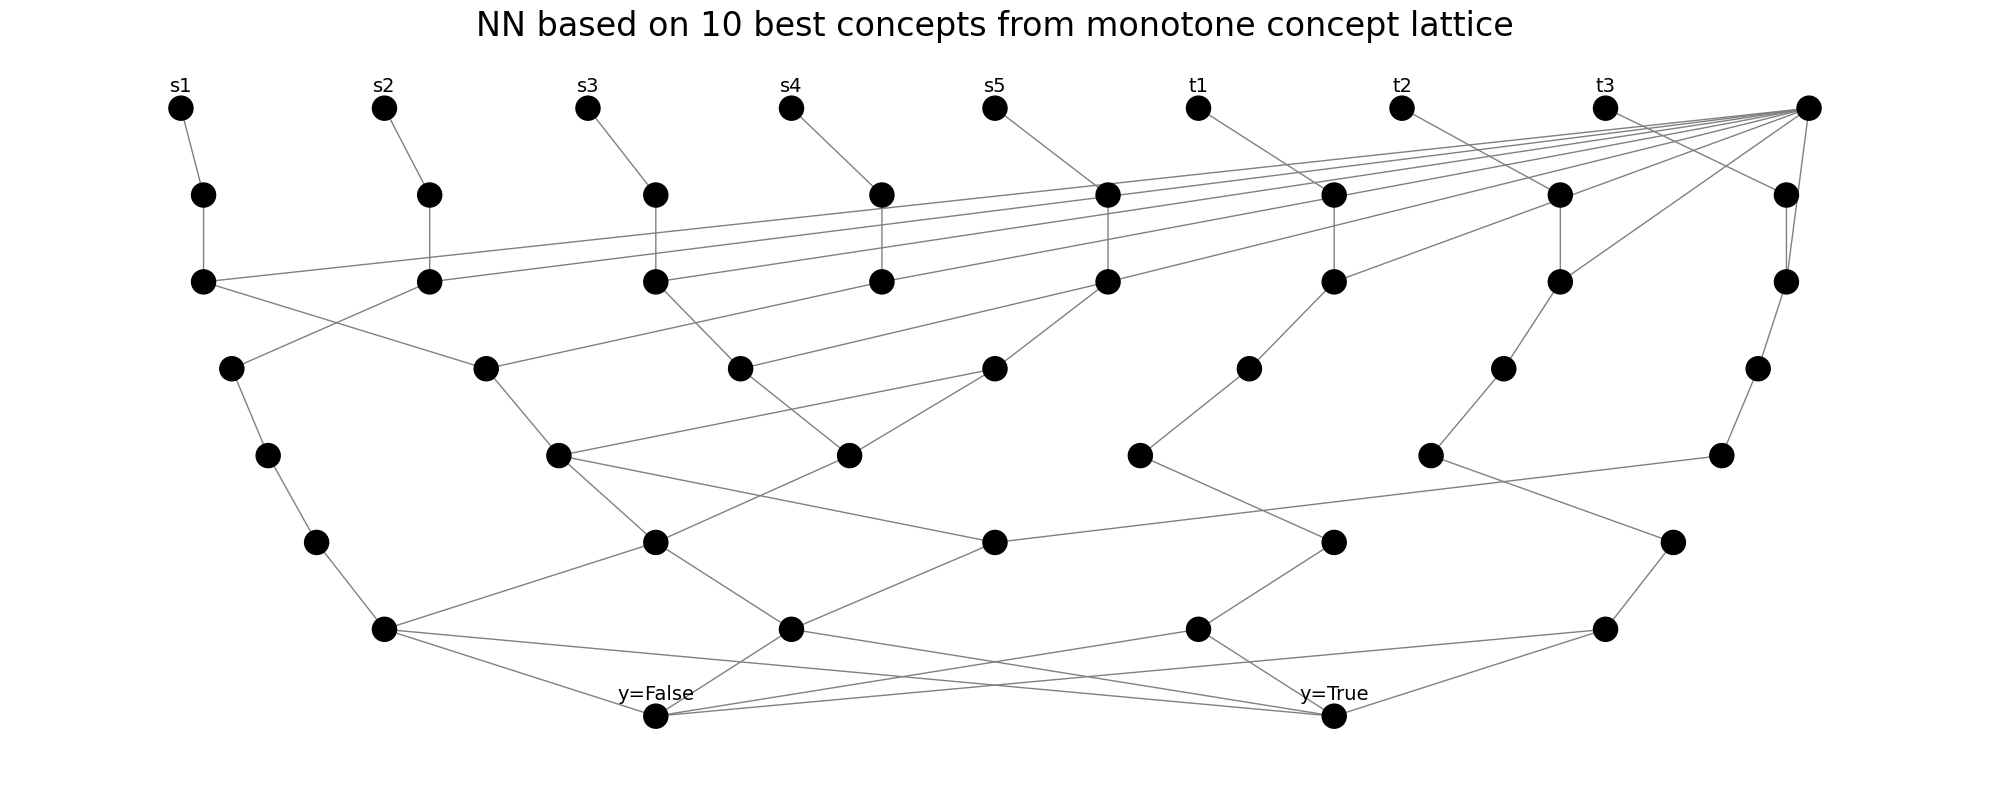

In [183]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [161]:
cn_1.fit(X_train, y_train['tar1'], n_epochs=500)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False False False False False False False False False False False
 False False False False False False False False False False False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


Now, let's check F1 score of our prediction

In [162]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 0.0


Let's look at the fitted weights of edges.

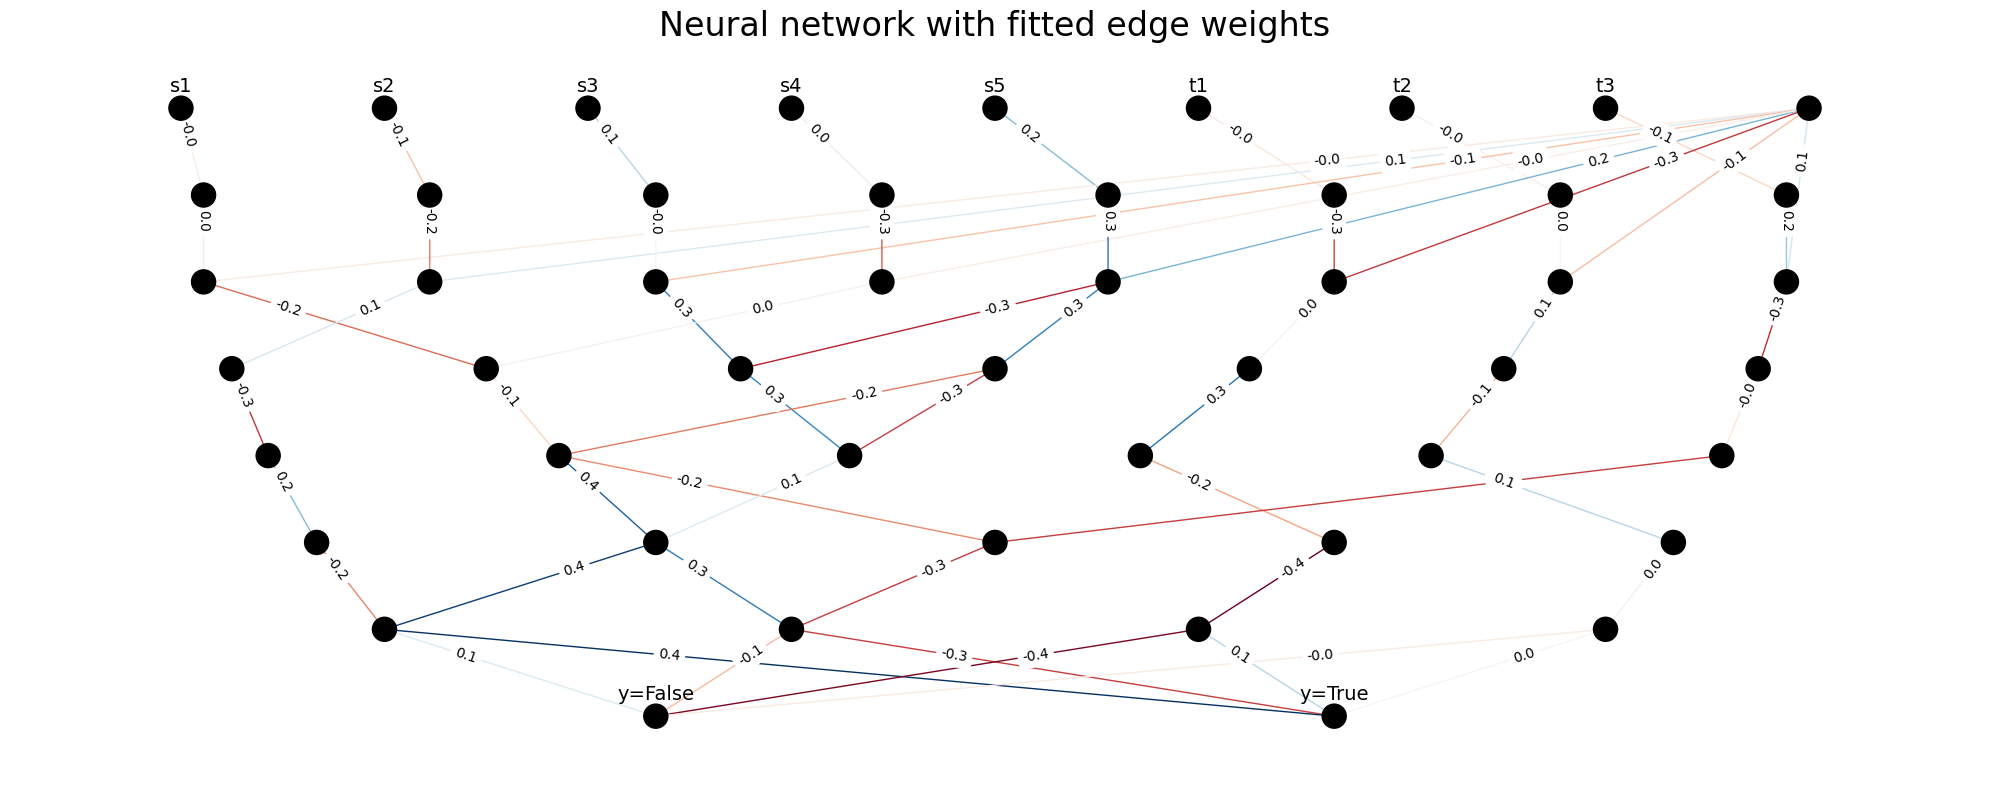

In [163]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Ok! We get very bad result. Let's go further!

### Applying Neural FCA on target 2

In [164]:
from sklearn.metrics import accuracy_score

for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['accuracy'] = accuracy_score(y_train['tar2'], y_preds)
    print(c.measures['accuracy'])

0.5729166666666666
0.8020833333333334
0.6770833333333334
0.5520833333333334
0.84375
0.8333333333333334
0.5729166666666666
0.75
0.71875
0.6770833333333334
0.6666666666666666
0.6041666666666666
0.59375
0.5833333333333334
0.5729166666666666
0.5416666666666666
0.5104166666666666
0.5
0.4791666666666667
0.4791666666666667
0.4583333333333333
0.4583333333333333
0.4270833333333333


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [165]:
concepts_count = 10
best_concepts = list(L.measures['accuracy'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [166]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [167]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

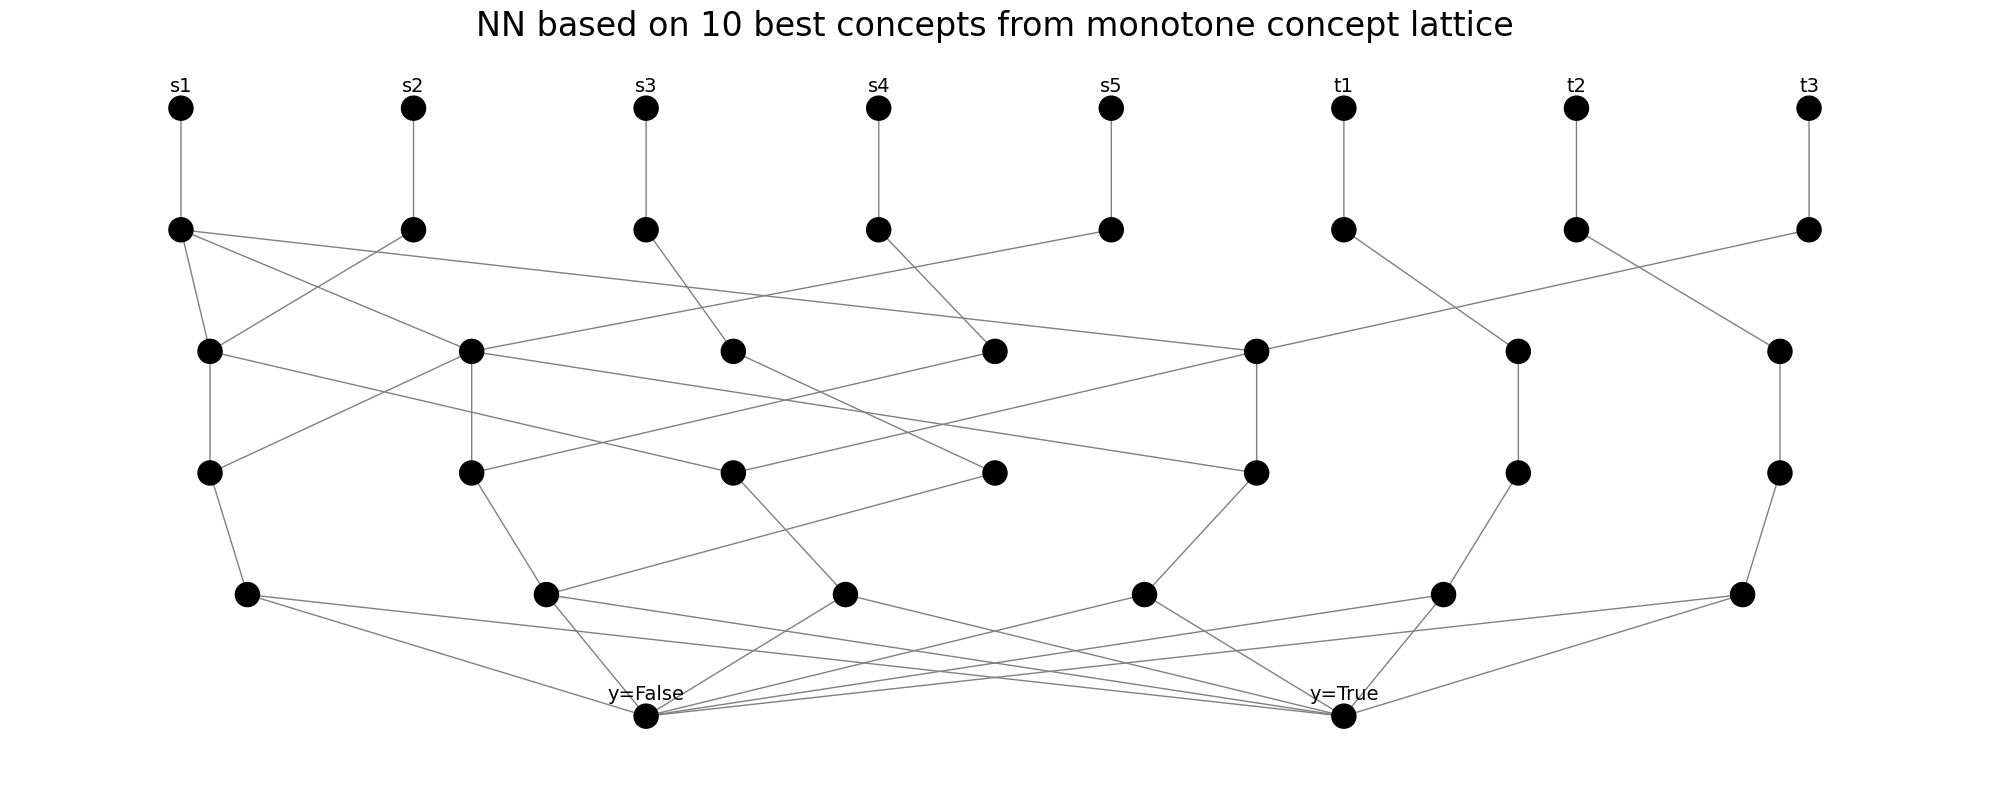

In [168]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [169]:
cn_2.fit(X_train, y_train['tar2'], n_epochs=500)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [False False  True False False False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


Now, let's check F1 score of our prediction

In [170]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 0.875


Let's look at the fitted weights of edges.

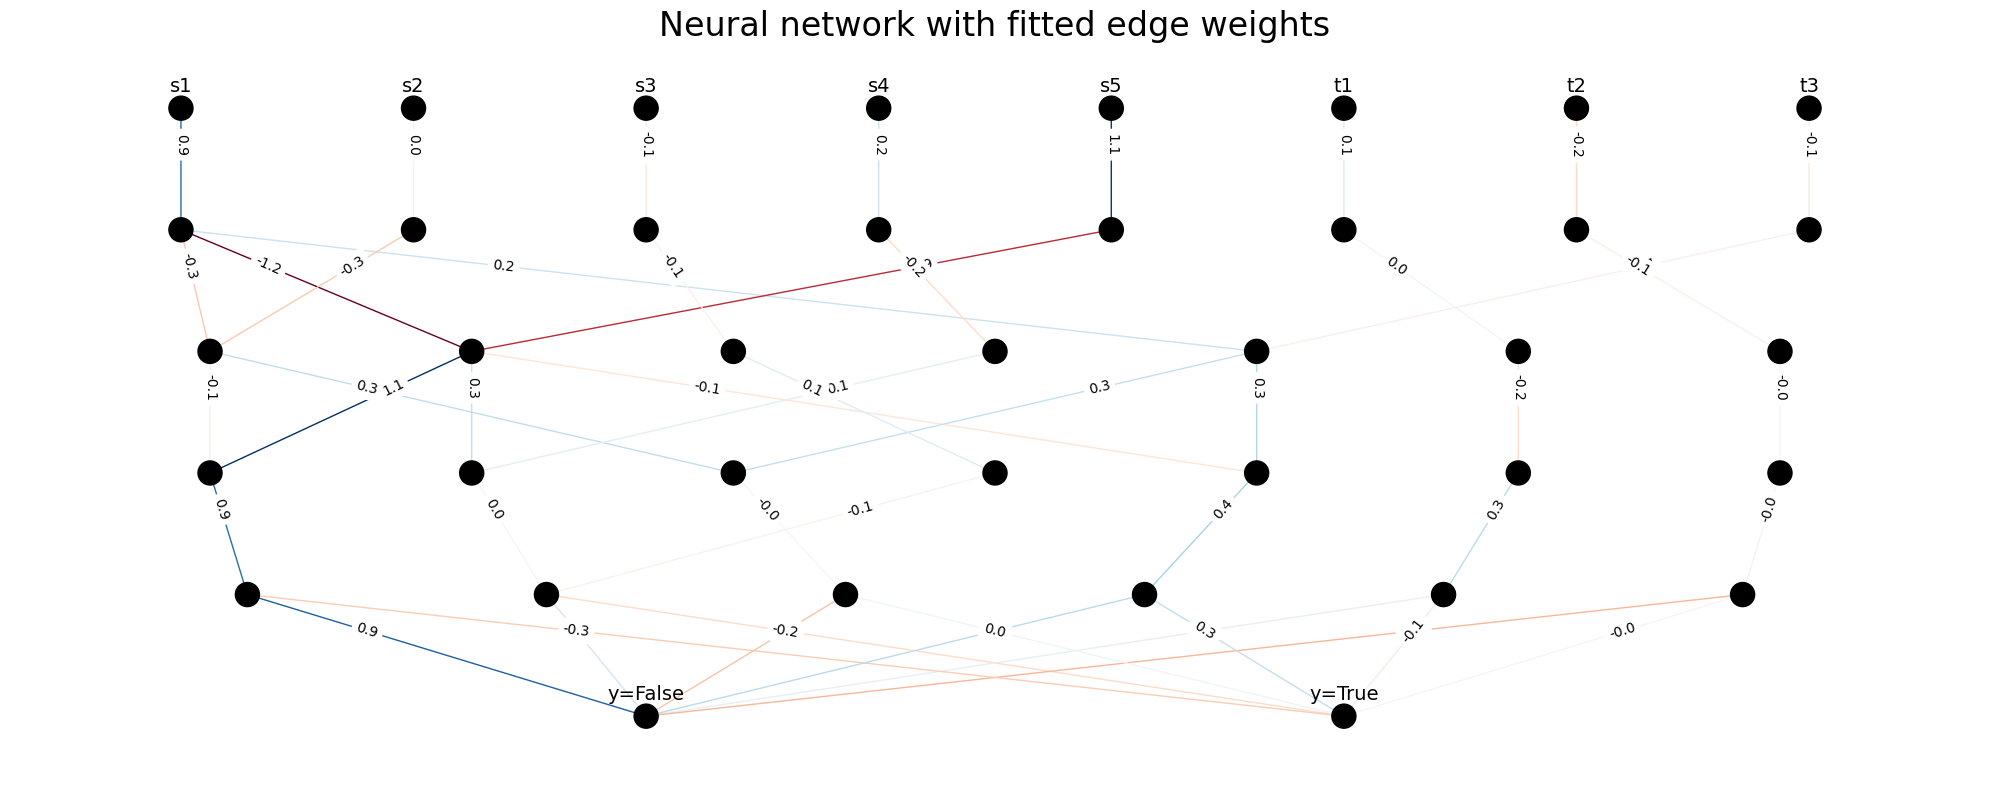

In [171]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Ok! We get very bad result. Our first approach was the best.

## The efficiency of various nonlinearities to put in the network

The default nonlinearity in the network is ReLU. Let's use our first and best model to test Leaky ReLU and hyperbolic tangent.

In [186]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

threshold = 38

# Create binary categories for temperature
X['t'] = np.where(X['t'] >= threshold, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't']]
X_cat

# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])

y = y.replace(['yes', 'no'], [True, False])

X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\343825636.py:46: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


s1     s2     s3     s4     s5      t
case 10   False  False   True   True   True  False
case 96   False   True   True  False   True   True
case 100  False   True   True  False   True   True
case 12   False   True  False  False  False  False
case 112   True   True  False   True  False   True
...         ...    ...    ...    ...    ...    ...
case 107  False  False  False  False  False   True
case 23   False  False   True   True   True  False
case 77   False   True   True  False   True   True
case 44   False  False   True  False  False  False
case 49   False  False   True   True  False  False

[96 rows x 6 columns]

### Finding the formal concepts

In [191]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 6 attributes, 277 connections)
        |s1|s2|s3|s4|s5|t|
case 10 |  |  | X| X| X| |
case 96 |  | X| X|  | X|X|
case 100|  | X| X|  | X|X|
case 12 |  | X|  |  |  | |
case 112| X| X|  | X|  |X|
case 43 |  |  | X|  |  | |
case 63 |  | X| X|  | X|X|
case 22 |  | X|  |  |  | |
case 62 |  | X| X|  | X|X|
case 24 |  |  | X| X| X| |
..........................
..........................
case 95 | X| X|  | X|  |X|
case 0  |  | X|  |  |  | |
case 57 |  | X|  |  |  | |
case 53 |  |  | X| X| X| |
case 79 | X| X| X| X| X|X|
case 107|  |  |  |  |  |X|
case 23 |  |  | X| X| X| |
case 77 |  | X| X|  | X|X|
case 44 |  |  | X|  |  | |
case 49 |  |  | X| X|  | |

In [192]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

20

### Applying Neural FCA on target 1

In [205]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.27956989247311825
0.5544554455445545
0.2549019607843137
0.5185185185185185
0.23853211009174313
0.8256880733944955
0.6727272727272727
0.6324786324786325
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.72
0.5873015873015873
0.556390977443609
0.6716417910447762
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [206]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [207]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [208]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

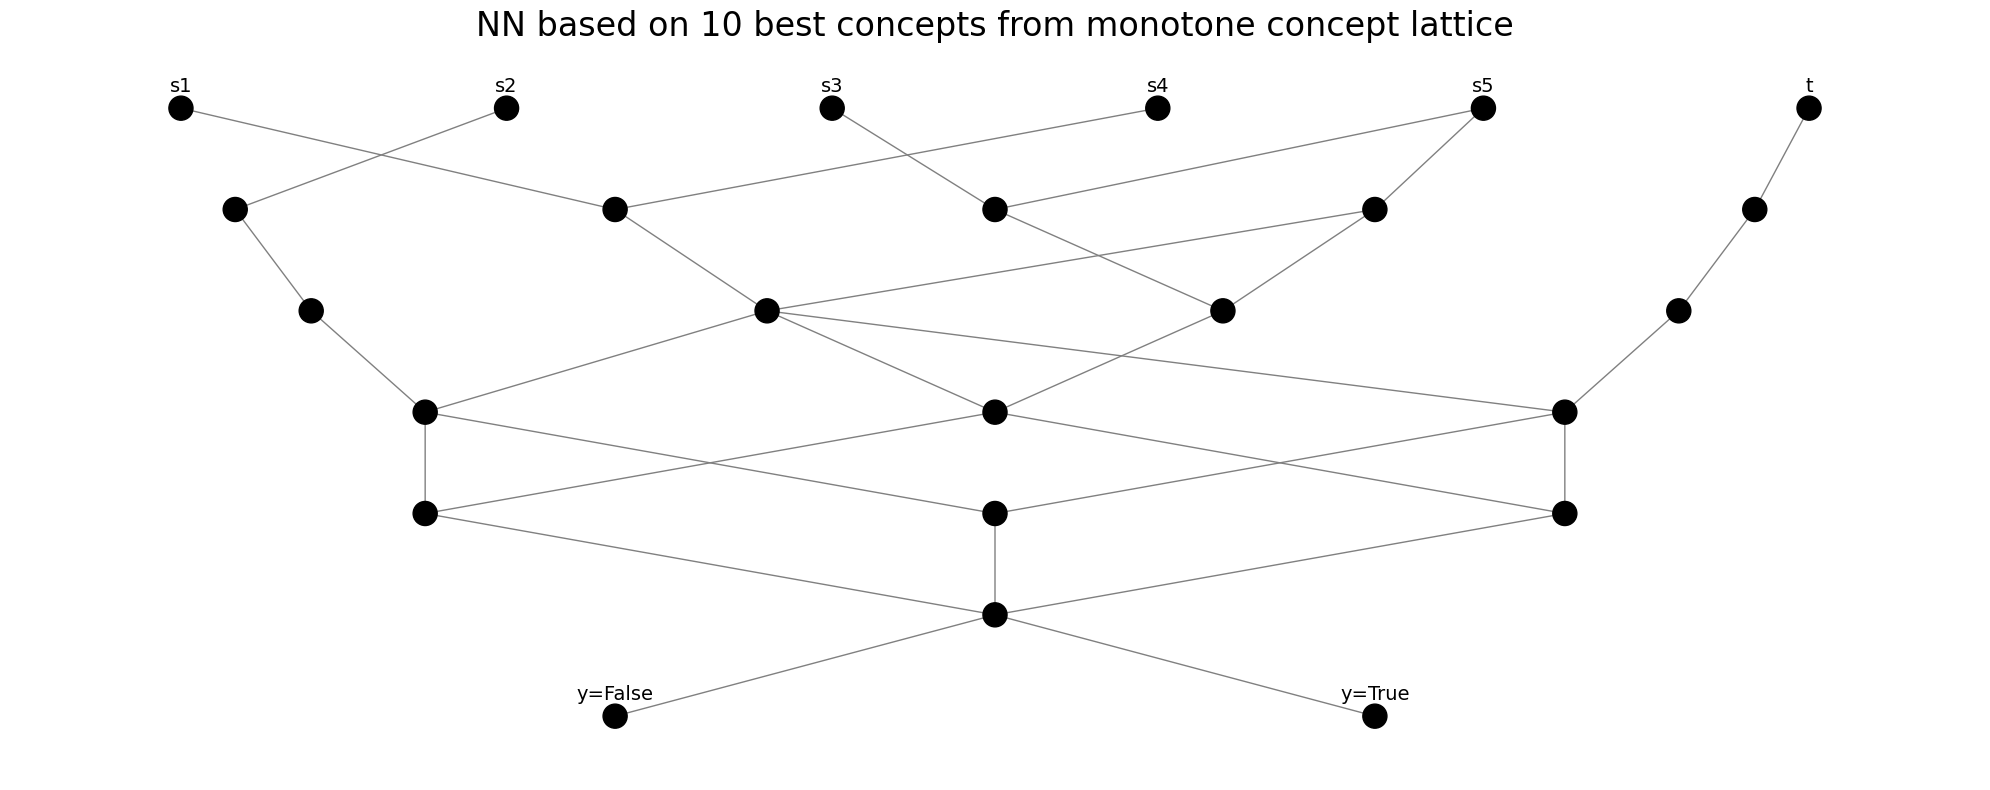

In [209]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [213]:
cn_1.fit(X_train, y_train["tar1"], nonlinearity=torch.nn.LeakyReLU, n_epochs=5000)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


In [214]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

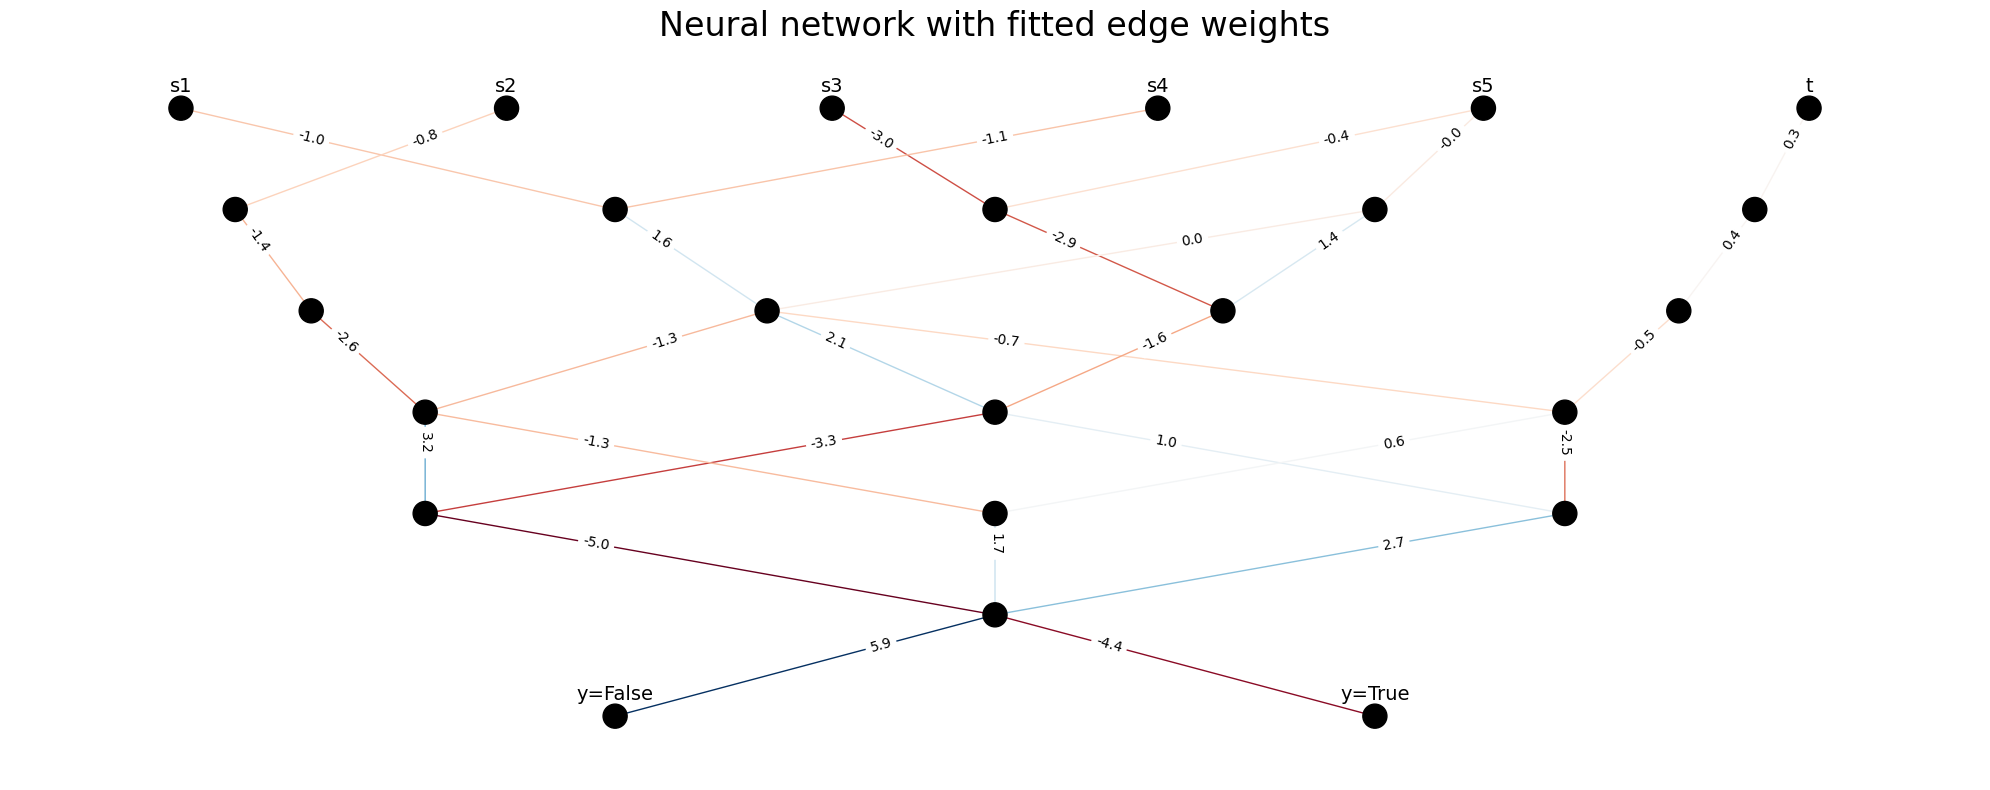

In [215]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Wow, we get the best possible result. Now, let's check  hyperbolic tangent.

In [216]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.27956989247311825
0.5544554455445545
0.2549019607843137
0.5185185185185185
0.23853211009174313
0.8256880733944955
0.6727272727272727
0.6324786324786325
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.72
0.5873015873015873
0.556390977443609
0.6716417910447762
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [217]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [218]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [219]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

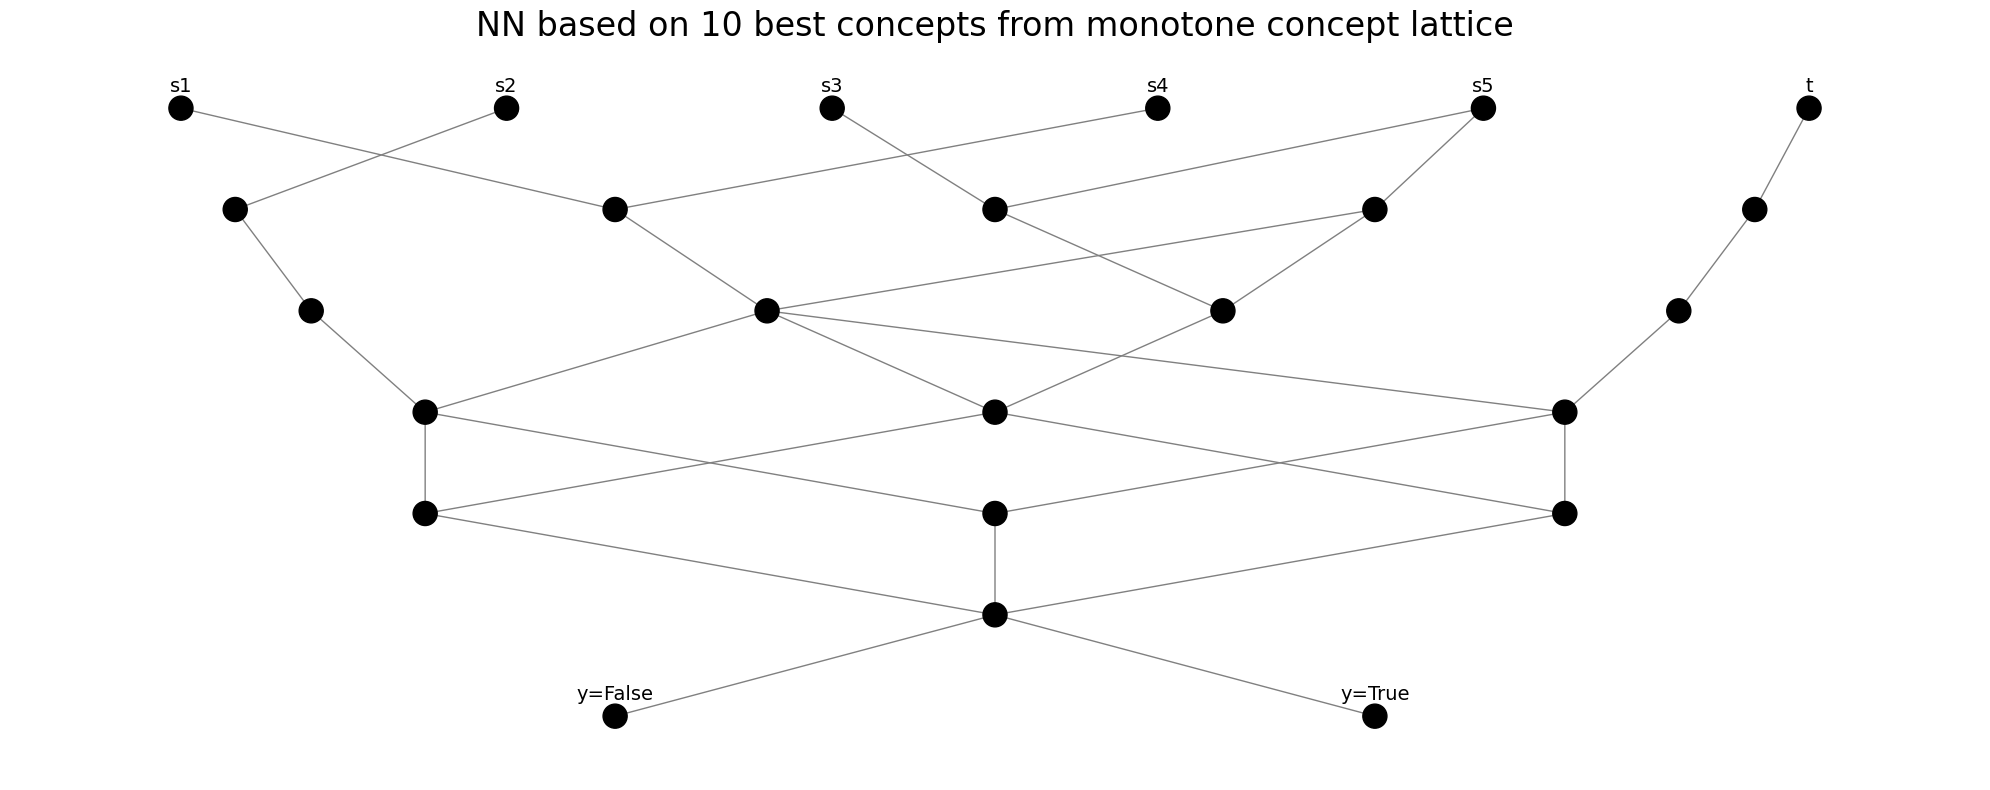

In [220]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [221]:
cn_1.fit(X_train, y_train["tar1"], nonlinearity=torch.nn.Tanh, n_epochs=5000)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


In [222]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

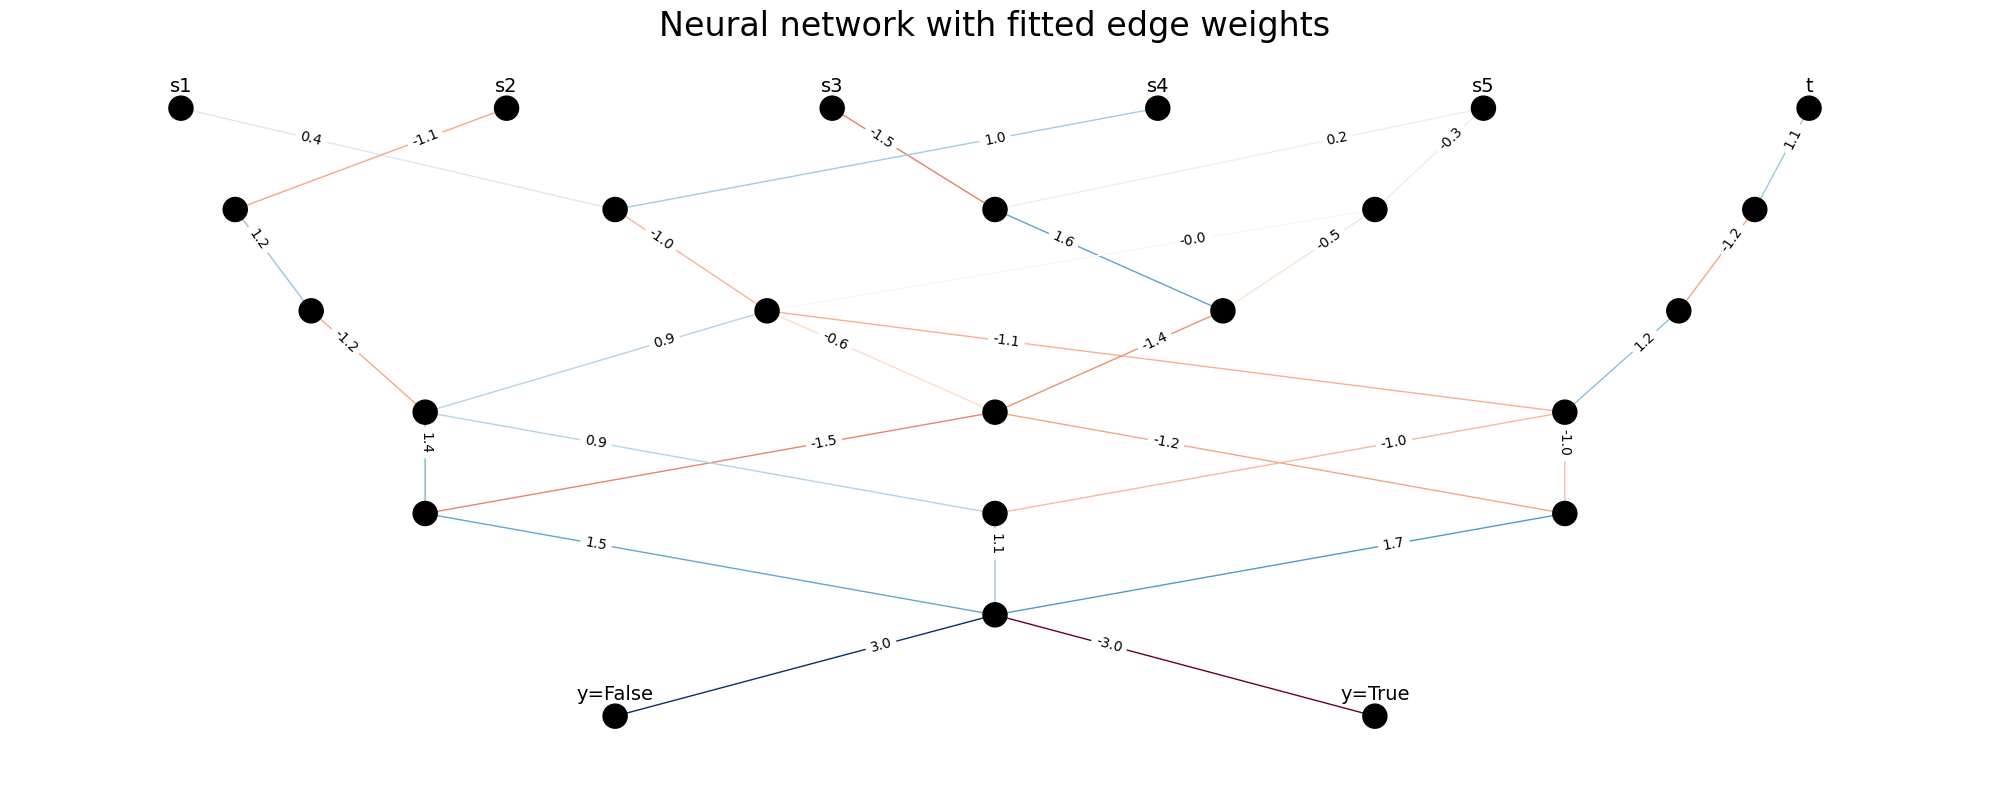

In [223]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

We got the best results using Leaky ReLU and hyperbolic tangent. Lets do the same for the second target.

### Applying Neural FCA on target 2

In [224]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar2'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.6984126984126984
0.6172839506172839
0.5057471264367817
0.9213483146067416
0.845360824742268
0.8367346938775511
0.7884615384615384
0.780952380952381
0.6095238095238096
0.7735849056603774
0.7256637168141593
0.7256637168141593
0.7192982456140351
0.6833333333333333
0.6776859504132231
0.6721311475409836
0.6356589147286822
0.6307692307692307
0.5985401459854015


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [225]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [226]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [227]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

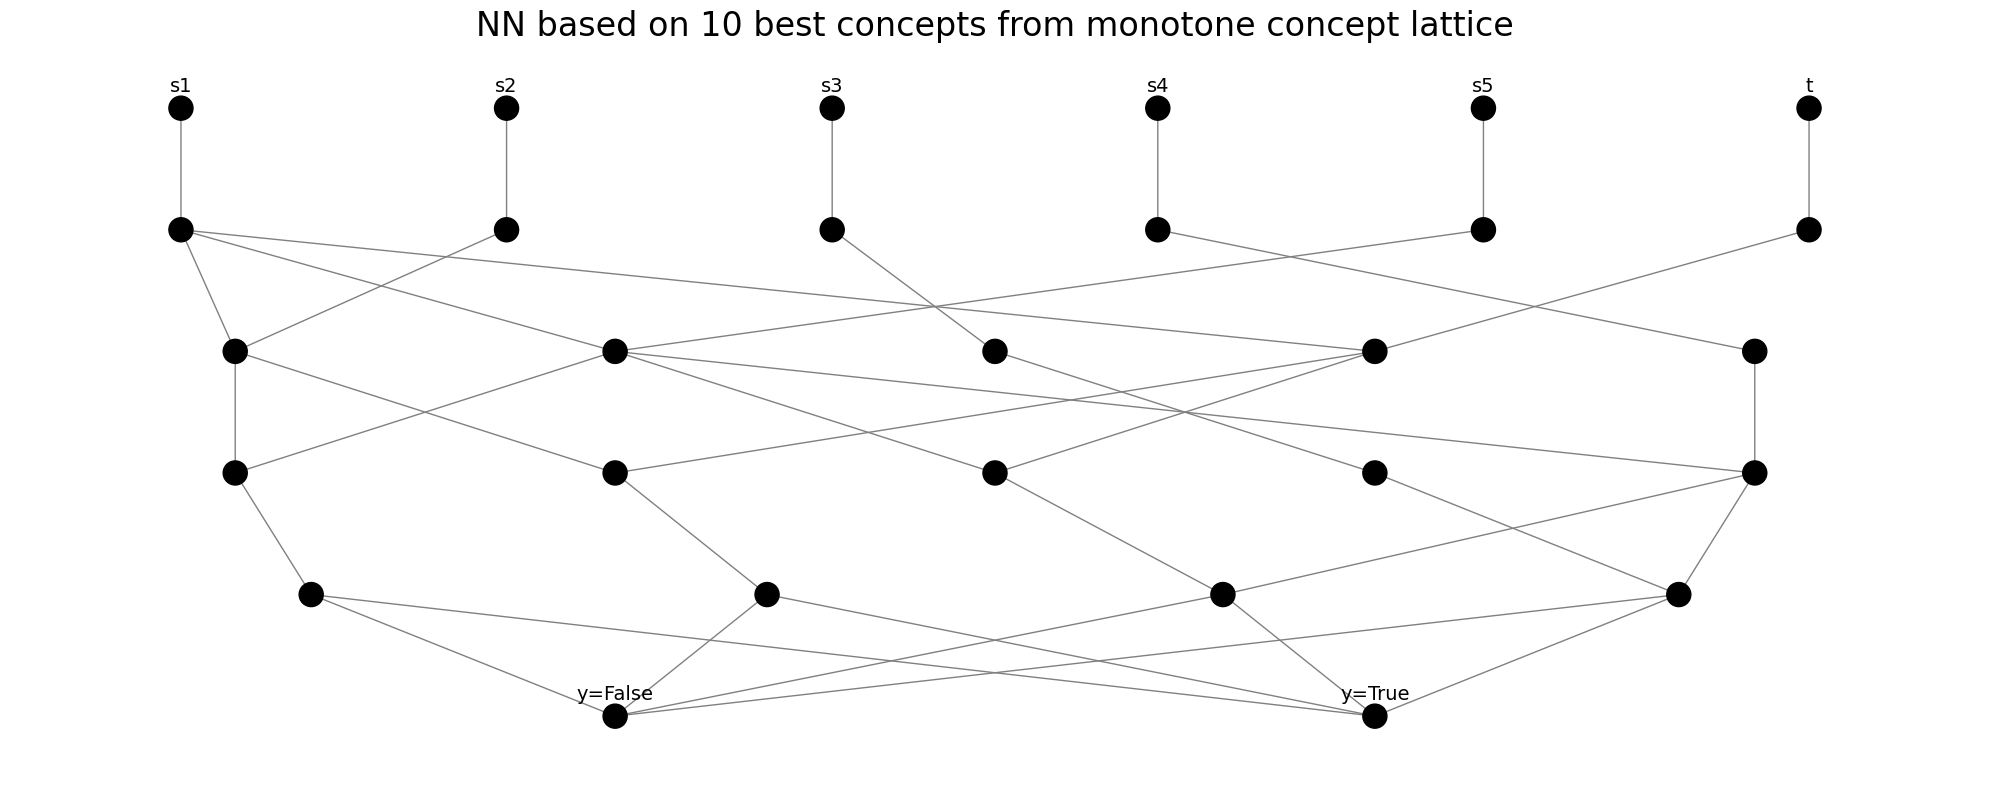

In [228]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [229]:
cn_2.fit(X_train, y_train["tar2"], nonlinearity=torch.nn.LeakyReLU, n_epochs=5000)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


In [230]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

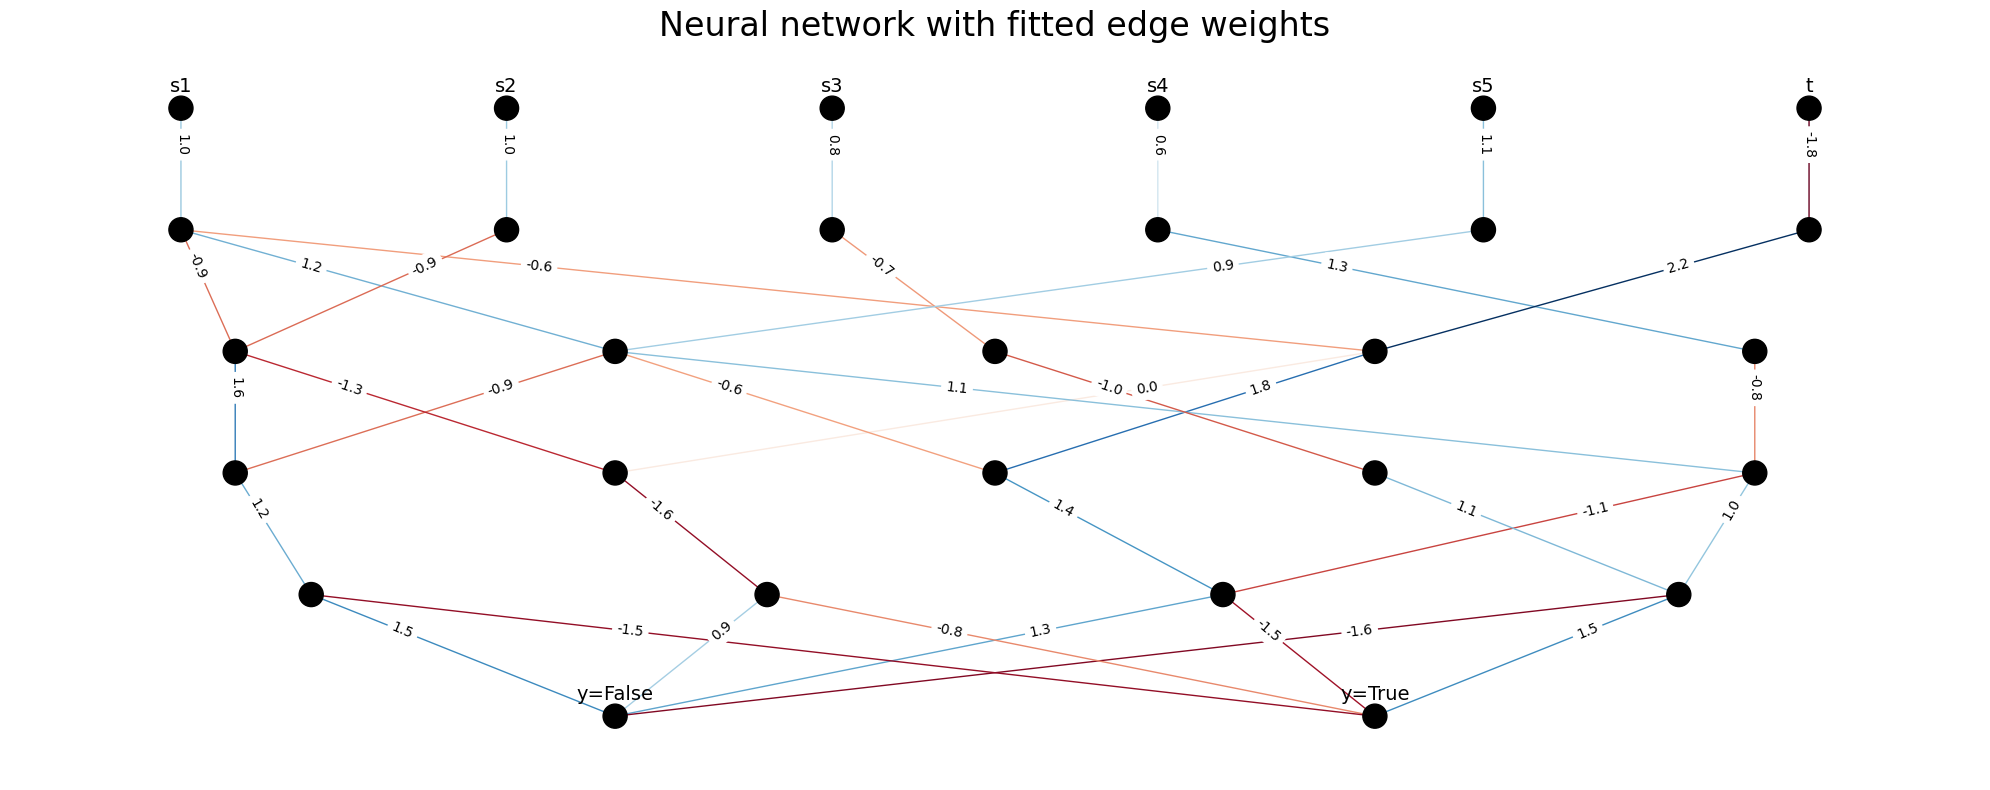

In [231]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Wow, we get the best possible result. Now, let's check  hyperbolic tangent.

In [232]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.27956989247311825
0.5544554455445545
0.2549019607843137
0.5185185185185185
0.23853211009174313
0.8256880733944955
0.6727272727272727
0.6324786324786325
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.72
0.5873015873015873
0.556390977443609
0.6716417910447762
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [233]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [234]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [235]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

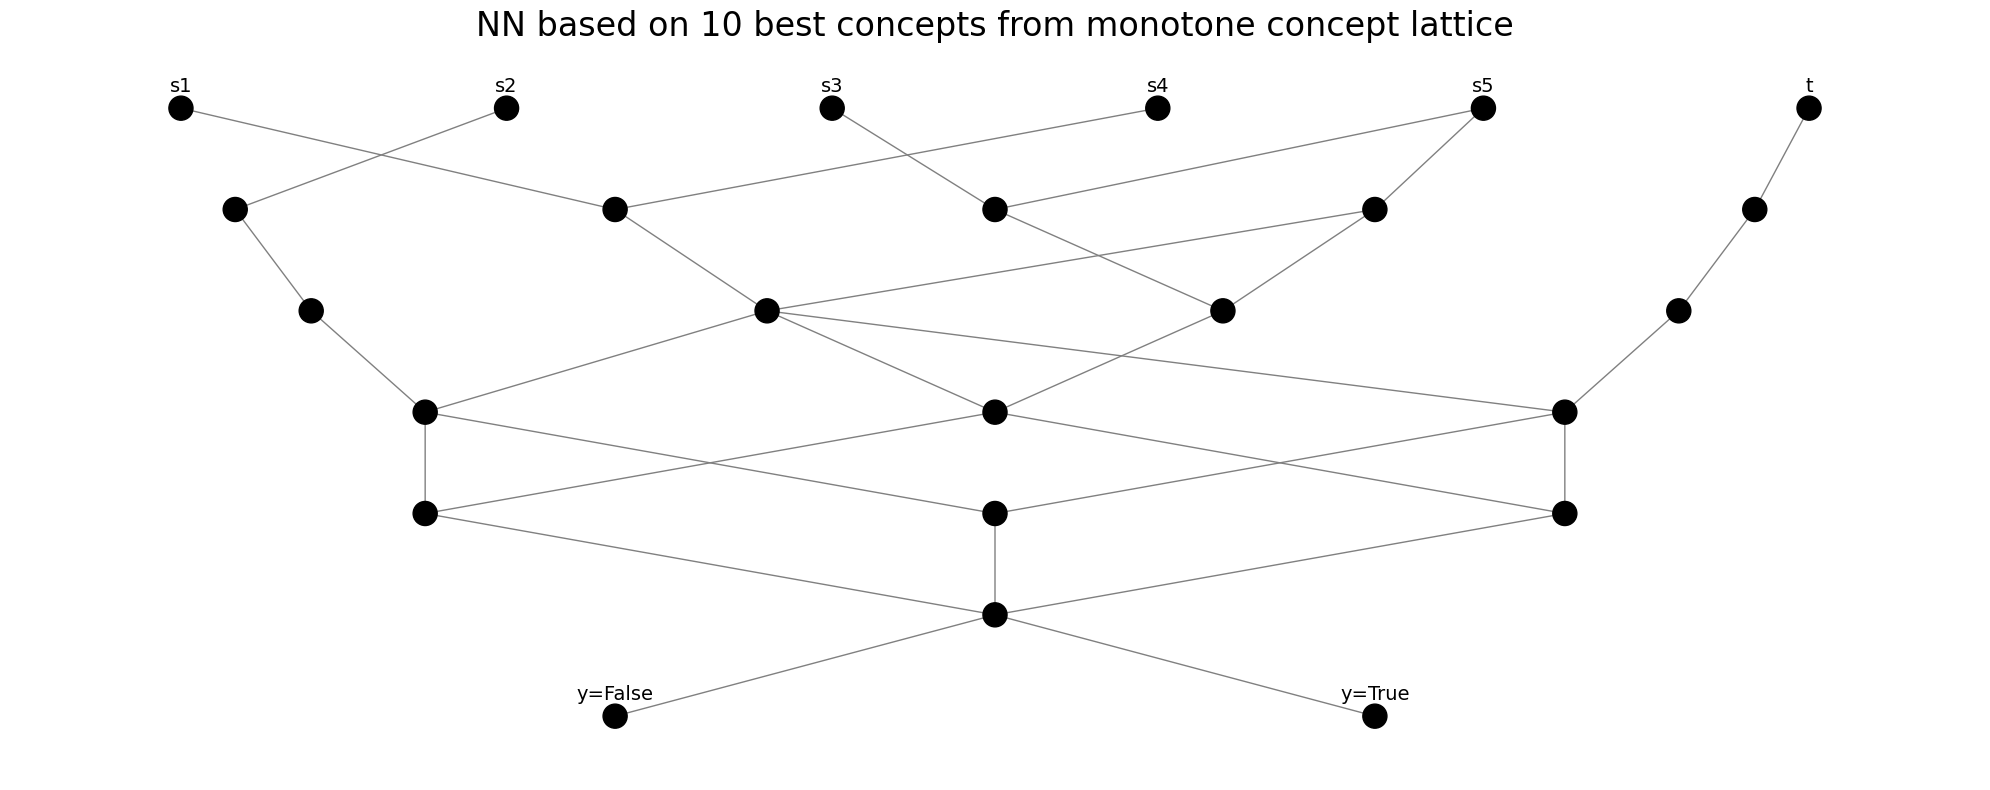

In [236]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [237]:
cn_2.fit(X_train, y_train["tar2"], nonlinearity=torch.nn.Tanh, n_epochs=5000)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


In [238]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

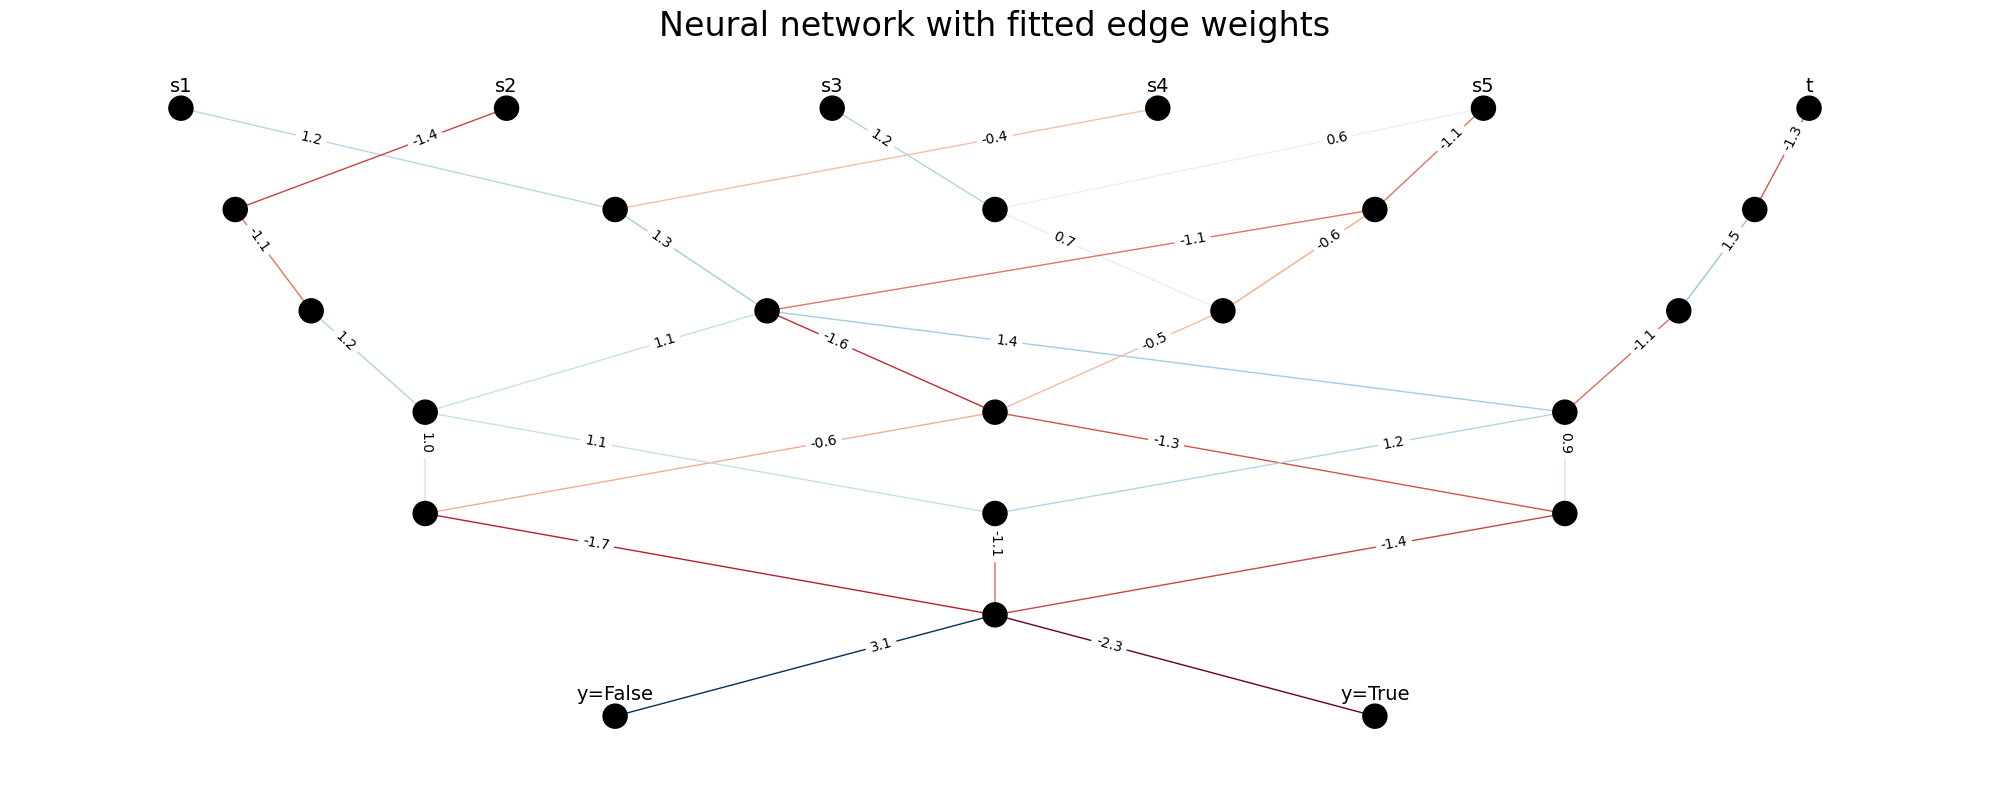

In [239]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

We got the best results using Leaky ReLU and hyperbolic tangent. Lets now compare with other state-of-the-art approaches.

## Let's do the same for the other binarized data

In [242]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Rename columns for better usability
X = X.rename(columns={
    "temperature": "t",
    "nausea": "s1",
    "lumbar-pain": "s2",
    "urine-pushing": "s3",
    "micturition-pains": "s4",
    "burning-urethra": "s5"
})

y = y.rename(columns={
    "bladder-inflammation": "tar1",
    "nephritis": "tar2"
})

threshold = 38

# Create binary categories for temperature
X['t1'] = np.where(X['t'] >= threshold_1, 'yes', 'no')
X['t2'] = np.where(X['t'] >= threshold_2, 'yes', 'no')
X['t3'] = np.where(X['t'] >= threshold_3, 'yes', 'no')

# Create binary attribute table
X_cat = X[['s1', 's2', 's3', 's4', 's5', 't1', 't2', 't3']]

# Convert 'yes' and 'no' to True and False
X_bin = X_cat.copy()

# Iterate over each column in the DataFrame
for col in X_bin.columns:
    # Map 'yes' to True and 'no' to False
    X_bin[col] = X_bin[col].map({'yes': True, 'no': False})

# Convert the entire DataFrame to boolean type
X_bin = X_bin.astype('bool')

s = pd.Series([f'case {i}' for i in range(X.shape[0])])
X_att = X_bin.set_index([s])

y = y.replace(['yes', 'no'], [True, False])

X_train, X_test, y_train, y_test = train_test_split(X_att, y, test_size=0.2, random_state=59, shuffle=True)
X_train

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\4013229374.py:47: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['yes', 'no'], [True, False])


s1     s2     s3     s4     s5    t1    t2     t3
case 10   False  False   True   True   True  True  True  False
case 96   False   True   True  False   True  True  True   True
case 100  False   True   True  False   True  True  True   True
case 12   False   True  False  False  False  True  True  False
case 112   True   True  False   True  False  True  True   True
...         ...    ...    ...    ...    ...   ...   ...    ...
case 107  False  False  False  False  False  True  True   True
case 23   False  False   True   True   True  True  True  False
case 77   False   True   True  False   True  True  True   True
case 44   False  False   True  False  False  True  True   True
case 49   False  False   True   True  False  True  True   True

[96 rows x 8 columns]

### Finding the formal concepts

In [243]:
K_train = FormalContext.from_pandas(X_train)
K_train

FormalContext (96 objects, 8 attributes, 481 connections)
        |s1|s2|s3|s4|s5|t1|t2|t3|
case 10 |  |  | X| X| X| X| X|  |
case 96 |  | X| X|  | X| X| X| X|
case 100|  | X| X|  | X| X| X| X|
case 12 |  | X|  |  |  | X| X|  |
case 112| X| X|  | X|  | X| X| X|
case 43 |  |  | X|  |  | X| X| X|
case 63 |  | X| X|  | X| X| X| X|
case 22 |  | X|  |  |  | X| X|  |
case 62 |  | X| X|  | X| X| X| X|
case 24 |  |  | X| X| X| X| X|  |
.................................
.................................
case 95 | X| X|  | X|  | X| X| X|
case 0  |  | X|  |  |  | X|  |  |
case 57 |  | X|  |  |  | X| X| X|
case 53 |  |  | X| X| X| X| X| X|
case 79 | X| X| X| X| X| X| X| X|
case 107|  |  |  |  |  | X| X| X|
case 23 |  |  | X| X| X| X| X|  |
case 77 |  | X| X|  | X| X| X| X|
case 44 |  |  | X|  |  | X| X| X|
case 49 |  |  | X| X|  | X| X| X|

In [244]:
L = ConceptLattice.from_context(K_train, is_monotone=True)
len(L)

23

### Applying Neural FCA on target 1

In [245]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.5544554455445545
0.2549019607843137
0.8256880733944955
0.6727272727272727
0.49557522123893805
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.64
0.5873015873015873
0.6614173228346457
0.6923076923076923
0.631578947368421
0.6716417910447762
0.5882352941176471
0.6617647058823529
0.6086956521739131
0.6086956521739131
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [246]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [247]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [248]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

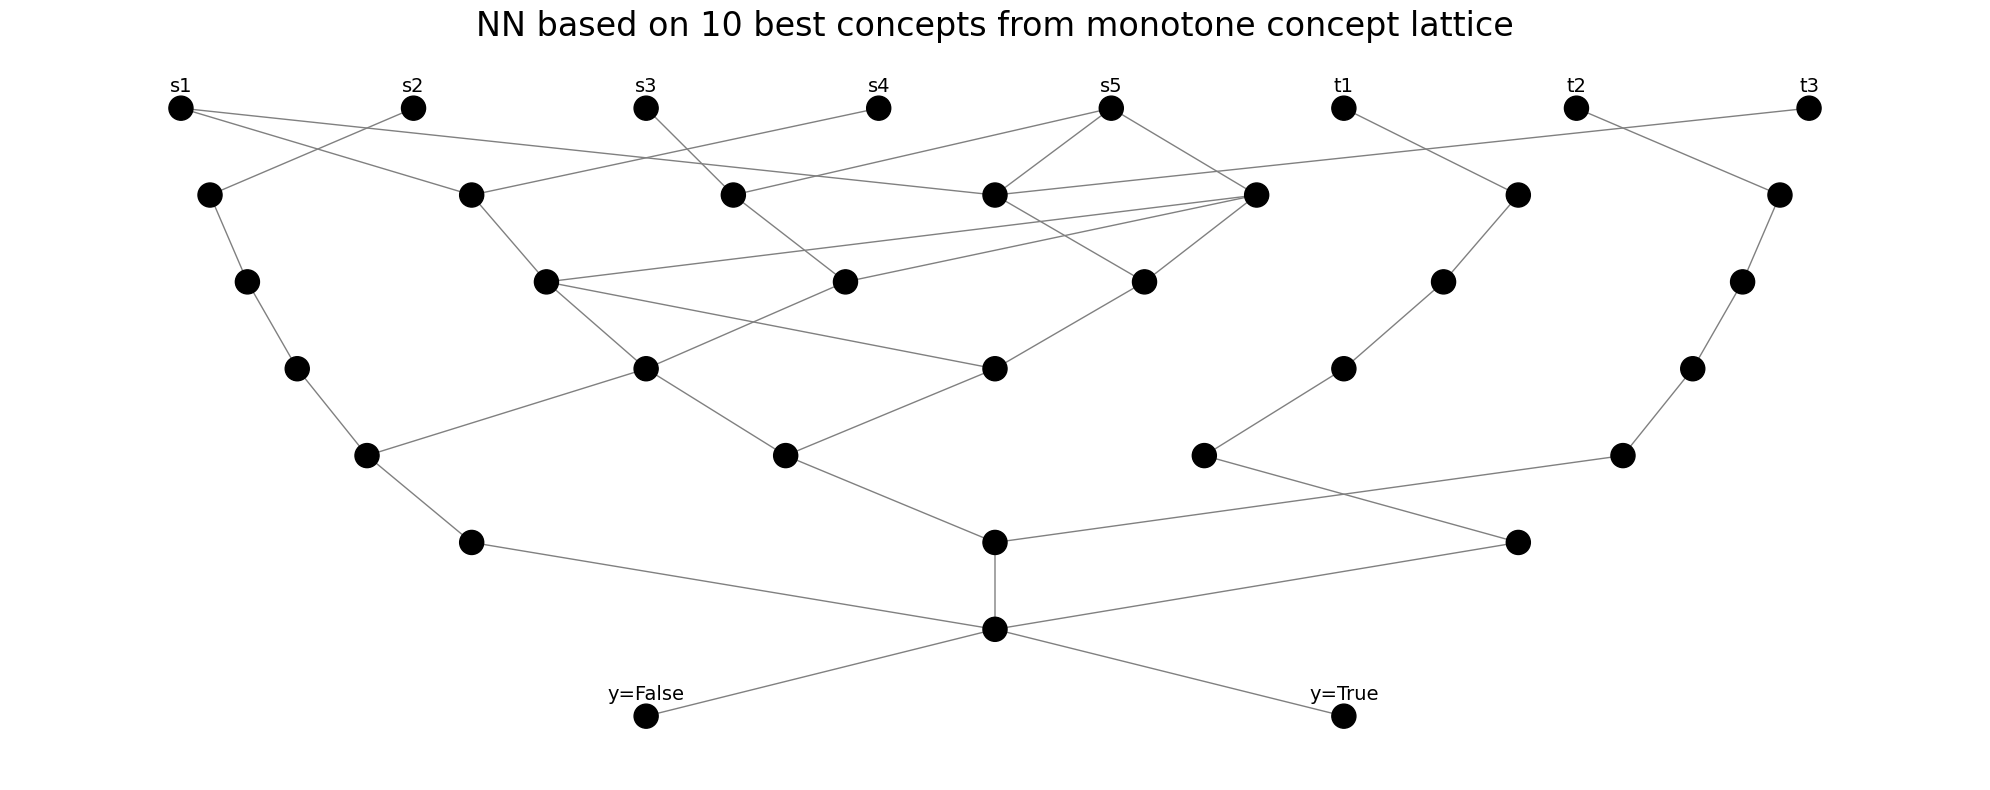

In [249]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [250]:
cn_1.fit(X_train, y_train["tar1"], nonlinearity=torch.nn.LeakyReLU, n_epochs=5000)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


In [251]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

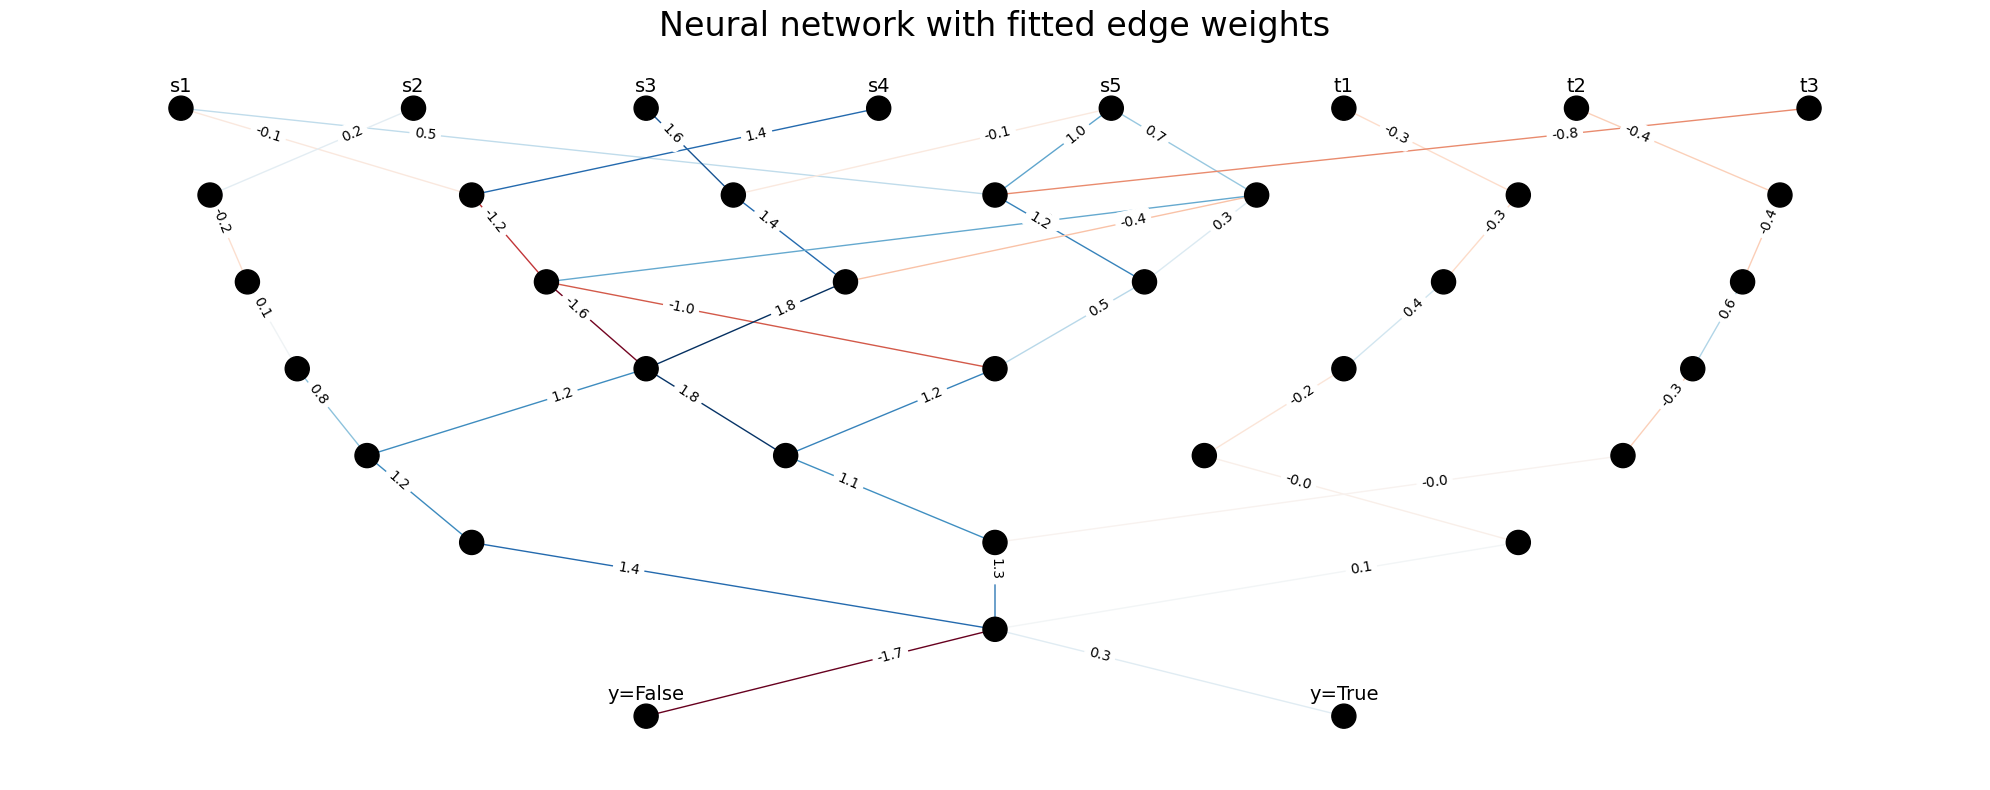

In [252]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Wow, we get the best possible result. Now, let's check  hyperbolic tangent.

In [253]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.5544554455445545
0.2549019607843137
0.8256880733944955
0.6727272727272727
0.49557522123893805
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.64
0.5873015873015873
0.6614173228346457
0.6923076923076923
0.631578947368421
0.6716417910447762
0.5882352941176471
0.6617647058823529
0.6086956521739131
0.6086956521739131
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [254]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [255]:
cn_1 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar1'])))

Setup visualizer for the architecture.

In [256]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

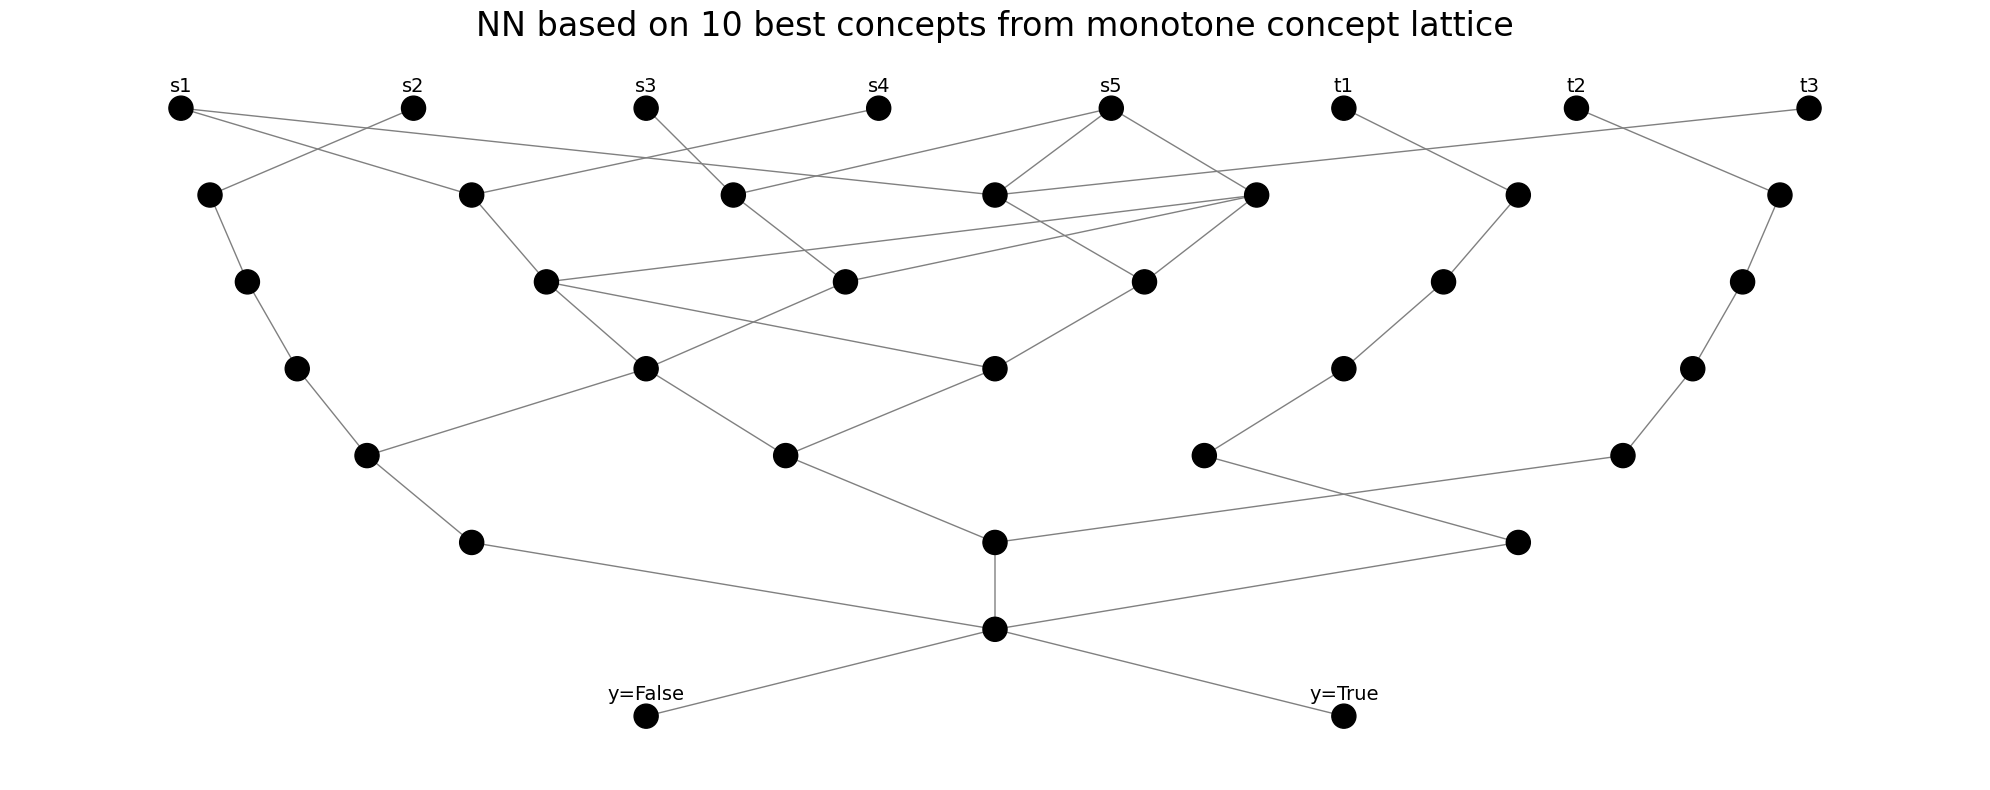

In [257]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [258]:
cn_1.fit(X_train, y_train["tar1"], nonlinearity=torch.nn.Tanh, n_epochs=5000)
print('Class predictions \n', cn_1.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar1'].values)

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]


In [259]:
print("F1 score =", f1_score(y_test['tar1'].values, cn_1.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

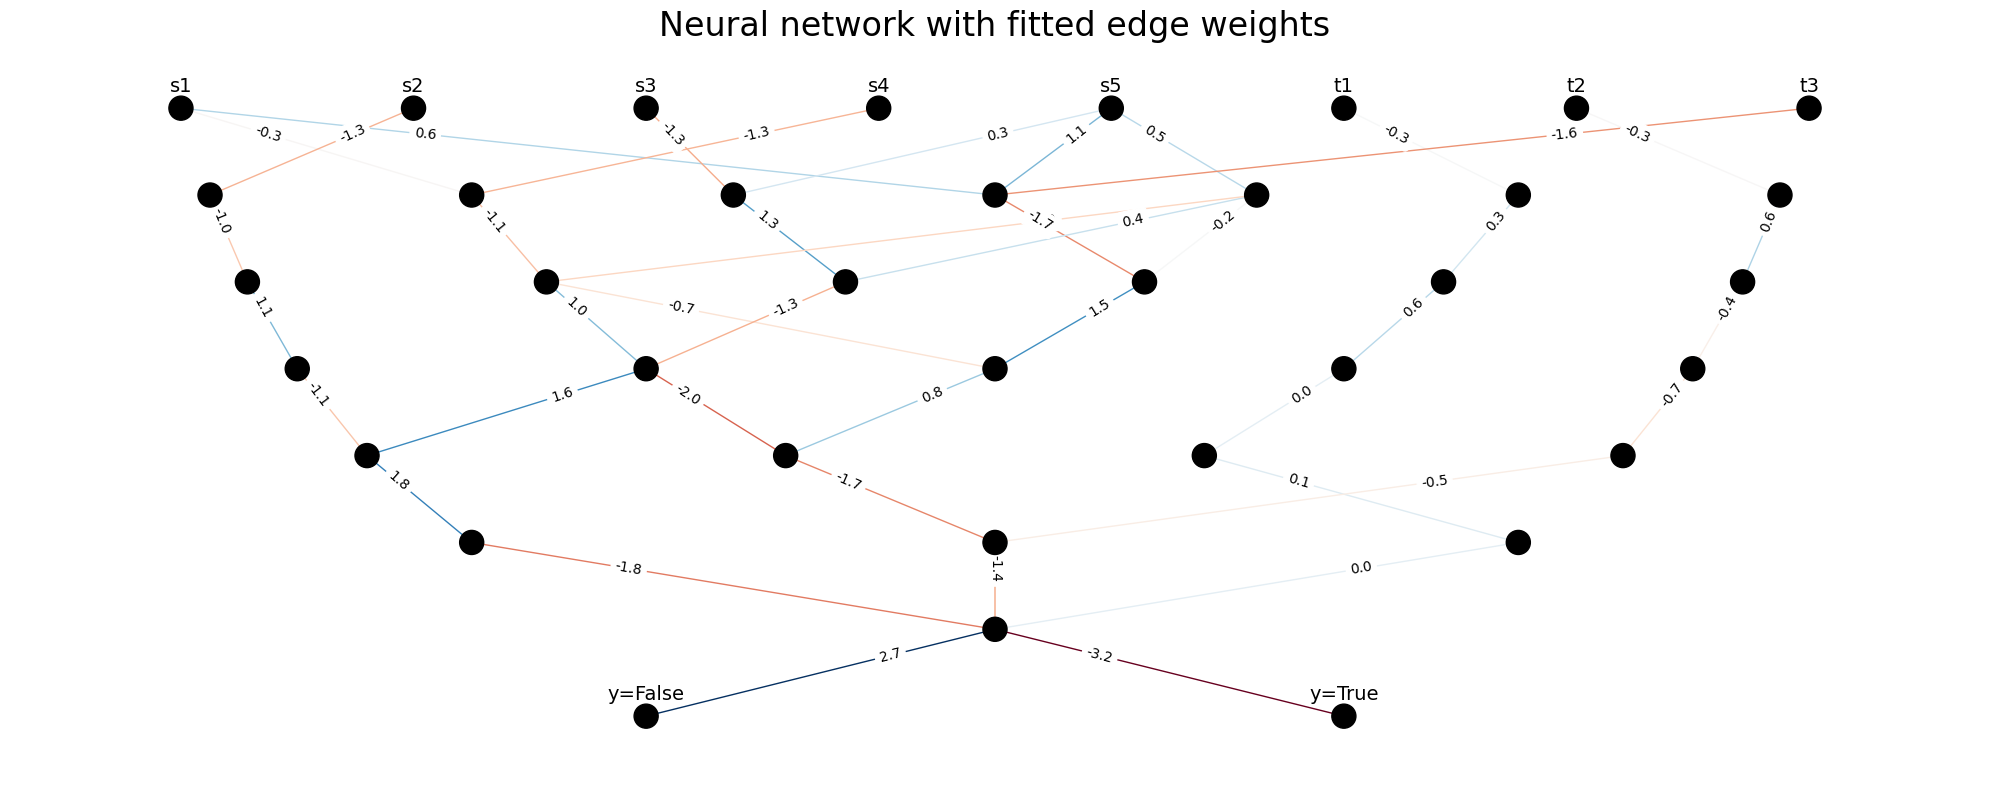

In [260]:
edge_weights = cn_1.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_1.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_1.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_1.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_1.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

We got the best results using Leaky ReLU and hyperbolic tangent. Lets do the same for the second target.

### Applying Neural FCA on target 2

In [261]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar2'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.6984126984126984
0.6172839506172839
0.5057471264367817
0.845360824742268
0.8367346938775511
0.6095238095238096
0.7735849056603774
0.7522935779816514
0.7256637168141593
0.7192982456140351
0.6833333333333333
0.6776859504132231
0.6721311475409836
0.6666666666666666
0.6507936507936508
0.6356589147286822
0.6307692307692307
0.6212121212121212
0.6212121212121212
0.6119402985074627
0.6119402985074627
0.5985401459854015


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [262]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [263]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [264]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

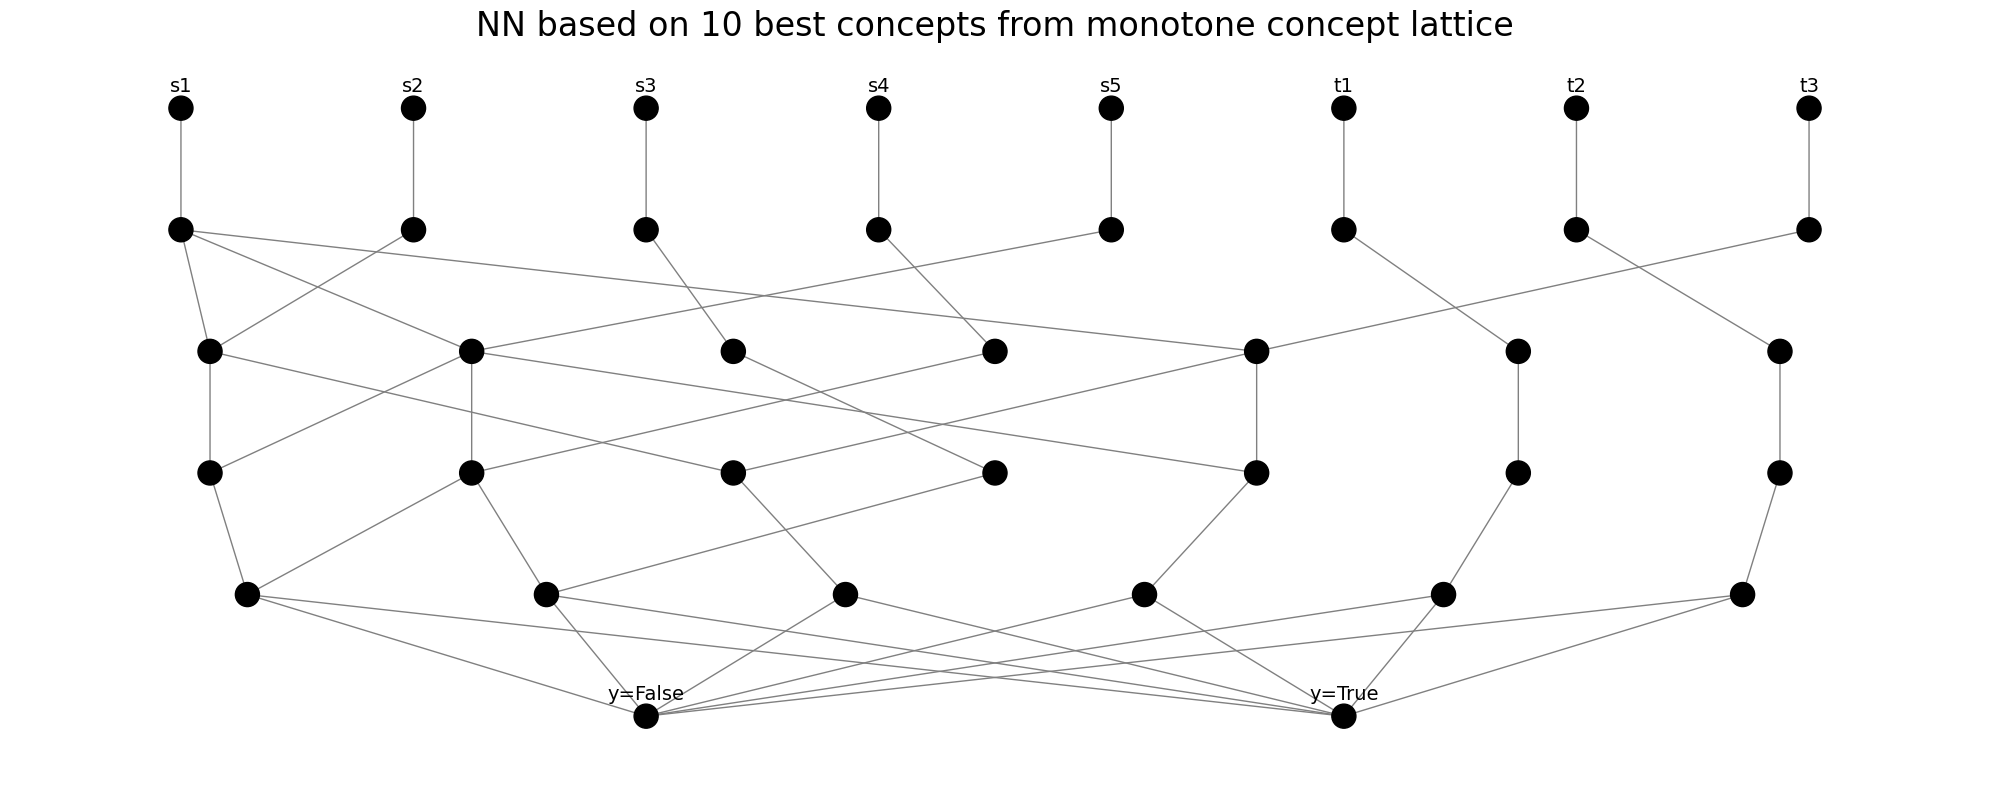

In [265]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

Now, we fit the network and get predictions

In [266]:
cn_2.fit(X_train, y_train["tar2"], nonlinearity=torch.nn.LeakyReLU, n_epochs=5000)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


In [267]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

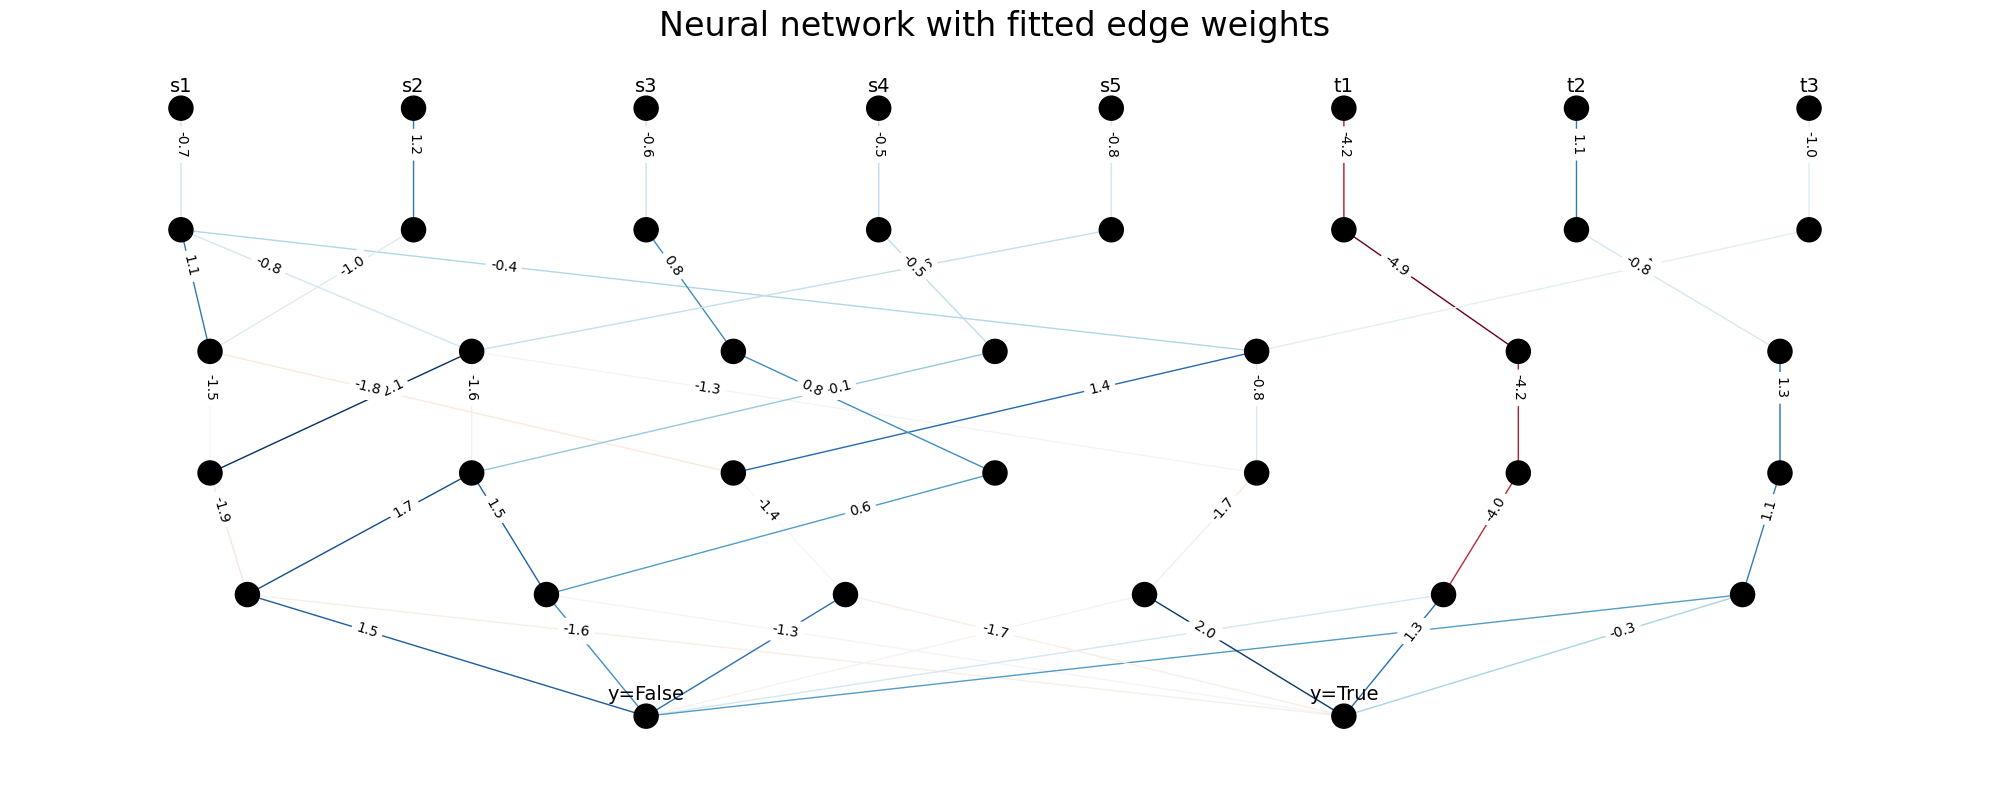

In [268]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

Wow, we get the best possible result. Now, let's check  hyperbolic tangent.

In [269]:
for c in L:
    y_preds = np.zeros(K_train.n_objects)
    y_preds[list(c.extent_i)] = 1
    c.measures['f1_score'] = f1_score(y_train['tar1'], y_preds)
    print(c.measures['f1_score'])
    c.measures['f1_score'] = float(c.measures['f1_score'])

0.0
0.3880597014925373
0.49411764705882355
0.8131868131868132
0.5544554455445545
0.2549019607843137
0.8256880733944955
0.6727272727272727
0.49557522123893805
0.47863247863247865
0.7627118644067796
0.45161290322580644
0.64
0.5873015873015873
0.6614173228346457
0.6923076923076923
0.631578947368421
0.6716417910447762
0.5882352941176471
0.6617647058823529
0.6086956521739131
0.6086956521739131
0.6382978723404256


Select indices of the best concepts from the lattice. I used top 10 concepts as they gave the best F1 score.

In [270]:
concepts_count = 10
best_concepts = list(L.measures['f1_score'].argsort()[::-1][:concepts_count])

assert len({g_i for c in L[best_concepts] for g_i in c.extent_i})==K_train.n_objects, "Selected concepts do not cover all train objects"

Now, let's construct neural network based on concept lattice.

In [271]:
cn_2 = nl.ConceptNetwork.from_lattice(L, best_concepts, sorted(set(y_train['tar2'])))

Setup visualizer for the architecture.

In [272]:
vis = LineVizNx(
    node_label_font_size=14,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes))+'\n\n',
    edge_cmap="hsv"
    )

And let's draw our architecture.

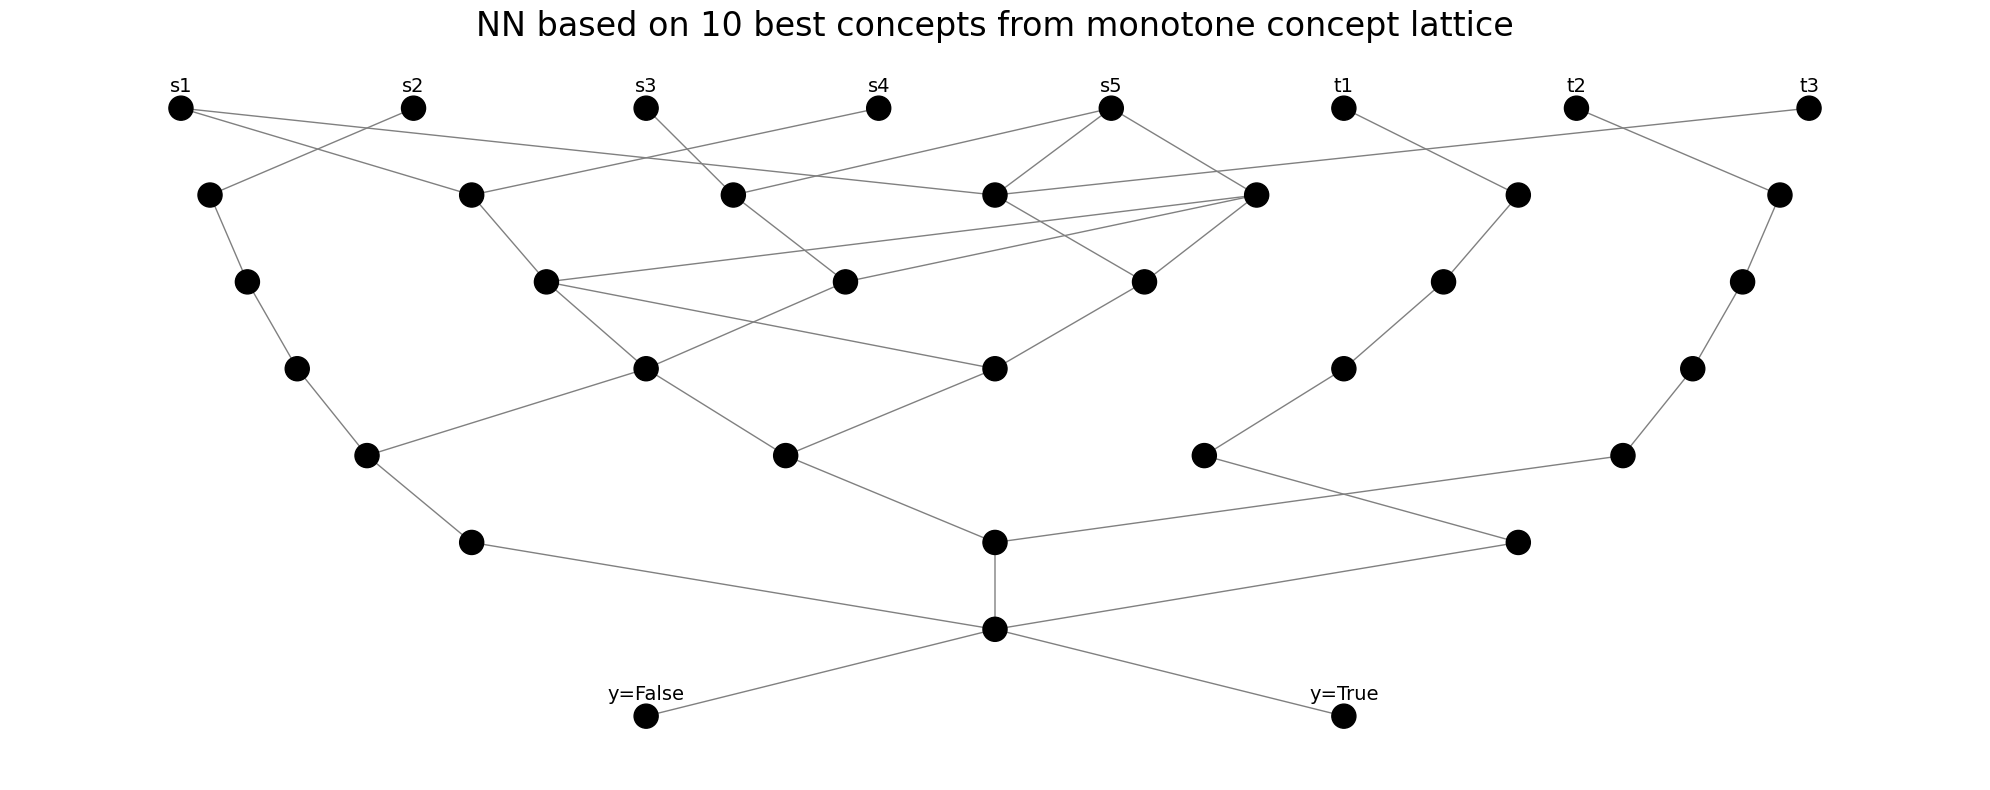

In [273]:
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, edge_color='grey',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    node_color='black',
)

plt.title(f'NN based on {concepts_count} best concepts from monotone concept lattice', loc='center', size=24)

plt.subplots_adjust()
plt.tight_layout()
plt.show()

In [274]:
cn_2.fit(X_train, y_train["tar2"], nonlinearity=torch.nn.Tanh, n_epochs=5000)
print('Class predictions \n', cn_2.predict(X_test).numpy().astype(bool))
print('True classes \n', y_test['tar2'].values)

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]


In [275]:
print("F1 score =", f1_score(y_test['tar2'].values, cn_2.predict(X_test).numpy()))

F1 score = 1.0


Let's look at the fitted weights of edges.

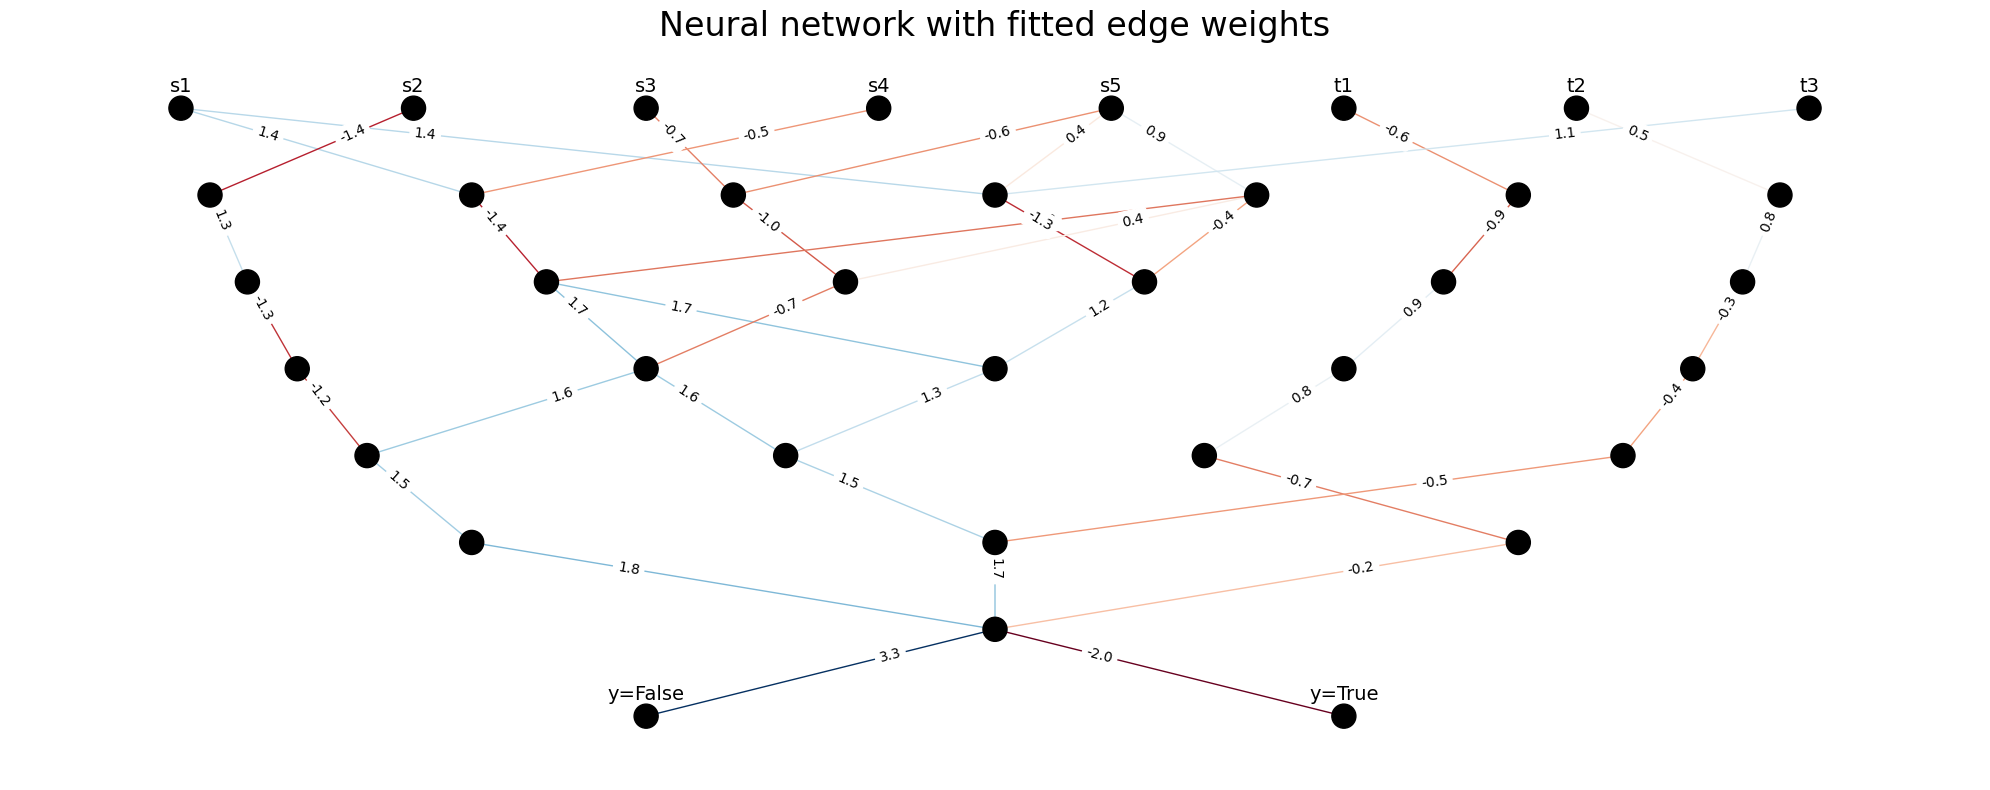

In [276]:
edge_weights = cn_2.edge_weights_from_network()
fig, ax = plt.subplots(figsize=(20,8))

vis.draw_poset(
    cn_2.poset, ax=ax, node_color='black',
    flg_node_indices=False,
    node_label_func=lambda el_i, P: nl.neuron_label_func(el_i, P, set(cn_2.attributes), only_new_attrs=True)+'\n\n',
    edge_color=[edge_weights[edge] for edge in cn_2.poset.to_networkx().edges],
    edge_cmap=plt.cm.RdBu,
)
nx.draw_networkx_edge_labels(cn_2.poset.to_networkx(), vis.mover.pos, {k: f"{v:.1f}" for k,v in edge_weights.items()}, label_pos=0.7)

plt.title('Neural network with fitted edge weights', size=24, loc='center')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

### We got the best results using Leaky ReLU and hyperbolic tangent. Lets now compare with other state-of-the-art approaches.

## Comparison of the prediction quality of the proposed model with State-of-the-Art approaches

### Fetch the dataset

In [ ]:
# Fetch the dataset
acute_inflammations = fetch_ucirepo(id=184)

# Extract features and targets
X = acute_inflammations.data.features
y = acute_inflammations.data.targets

# Get feature and target names
feature_names = acute_inflammations.data.feature_names
target_names = acute_inflammations.data.target_names

# Create pandas DataFrames
df_X = pd.DataFrame(X, columns=feature_names)
df_y = pd.DataFrame(y, columns=target_names)

# Combine features and targets into a single DataFrame
df = pd.concat([df_X, df_y], axis=1)

# Verify the combined DataFrame
df.head()

temperature nausea lumbar-pain urine-pushing micturition-pains  \
0         35.5     no         yes            no                no   
1         35.9     no          no           yes               yes   
2         35.9     no         yes            no                no   
3         36.0     no          no           yes               yes   
4         36.0     no         yes            no                no   

  burning-urethra bladder-inflammation nephritis  
0              no                   no        no  
1             yes                  yes        no  
2              no                   no        no  
3             yes                  yes        no  
4              no                   no        no

Convert 'yes' and 'no' to True and false

In [292]:
columns_to_convert = [col for col in df_X.columns if df_X[col].dtype == 'object' and set(df_X[col].unique()) == {'yes', 'no'}]
df_X[columns_to_convert] = df_X[columns_to_convert].replace({'yes': True, 'no': False})

columns_to_convert = [col for col in df_y.columns if df_y[col].dtype == 'object' and set(df_y[col].unique()) == {'yes', 'no'}]
df_y[columns_to_convert] = df_y[columns_to_convert].replace({'yes': True, 'no': False})
df_X.head()

C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\3659544738.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_X[columns_to_convert] = df_X[columns_to_convert].replace({'yes': True, 'no': False})
C:\Users\Askeladd\AppData\Local\Temp\ipykernel_21524\3659544738.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_y[columns_to_convert] = df_y[columns_to_convert].replace({'yes': True, 'no': False})


temperature  nausea  lumbar-pain  urine-pushing  micturition-pains  \
0         35.5   False         True          False              False   
1         35.9   False        False           True               True   
2         35.9   False         True          False              False   
3         36.0   False        False           True               True   
4         36.0   False         True          False              False   

   burning-urethra  
0            False  
1             True  
2            False  
3             True  
4            False

### Logistic Regression

Let's first apply logistic regression to the first target attribute 'bladder-inflammation'

In [298]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=17)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

lr.fit(X_train, y_train)

print('Class predictions \n', lr.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, lr.predict(X_test)))

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


C:\Users\Askeladd\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Now we apply logistic regression to the second target attribute 'nephritis'

In [299]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

lr.fit(X_train, y_train)

print('Class predictions \n', lr.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, lr.predict(X_test)))

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


Both resulted in the best possible f1 score.

### Random Forest Classifier

Let's first apply Random Forest Classifier to the first target attribute 'bladder-inflammation'

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=17)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

rf.fit(X_train, y_train)

print('Class predictions \n', rf.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, rf.predict(X_test)))

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Now we apply random forest classifier to the second target attribute 'nephritis'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

rf.fit(X_train, y_train)

print('Class predictions \n', rf.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, rf.predict(X_test)))

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


Both resulted in the best possible f1 score.

### Decision Tree Classifier

Let's first apply Decision Tree Classifier to the first target attribute 'bladder-inflammation'

In [303]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=17)

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

dt.fit(X_train, y_train)

print('Class predictions \n', dt.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, dt.predict(X_test)))

Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Now we apply decision tree classifier to the second target attribute 'nephritis'

In [304]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

dt.fit(X_train, y_train)

print('Class predictions \n', dt.predict(X_test).astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test.values, dt.predict(X_test)))

Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


Both resulted in the best possible f1 score.

### XGBoost

Let's first apply XGBoost to the first target attribute 'bladder-inflammation'

In [311]:
!pip install xgboost

from xgboost import XGBClassifier

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=17, eval_metric='logloss')

# Train the classifier
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
print('XGBoost Classifier:')
print('Class predictions \n', y_pred_xgb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_xgb))

Defaulting to user installation because normal site-packages is not writeable
XGBoost Classifier:
Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Now we apply XGBoost to the second target attribute 'nephritis'

In [312]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the XGBoost classifier
xgb = XGBClassifier(random_state=17, eval_metric='logloss')

# Train the classifier
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Evaluate the model
print('XGBoost Classifier:')
print('Class predictions \n', y_pred_xgb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_xgb))

XGBoost Classifier:
Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


Both resulted in the best possible f1 score.

### CatBoost

Let's apply CatBoost to the first target attribute 'bladder-inflammation'

In [319]:
!pip install catboost

from catboost import CatBoostClassifier

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the CatBoost classifier
cb = CatBoostClassifier(random_state=17, verbose=0)

# Train the classifier
cb.fit(X_train, y_train)

# Make predictions
y_pred_cb = cb.predict(X_test)

# Evaluate the model
print('CatBoost Classifier:')
print('Class predictions \n', y_pred_cb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_cb))

Defaulting to user installation because normal site-packages is not writeable
CatBoost Classifier:
Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Now we apply CatBoost to the second target attribute 'nephritis'

In [320]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the CatBoost classifier
cb = CatBoostClassifier(random_state=17, verbose=0)

# Train the classifier
cb.fit(X_train, y_train)

# Make predictions
y_pred_cb = cb.predict(X_test)

# Evaluate the model
print('CatBoost Classifier:')
print('Class predictions \n', y_pred_cb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_cb))

CatBoost Classifier:
Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


### KNN

Let's apply KNN to the first target attribute 'bladder-inflammation'

In [321]:
from sklearn.neighbors import KNeighborsClassifier

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the KNN classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print('K-Nearest Neighbors Classifier:')
print('Class predictions \n', y_pred_knn.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_knn))

K-Nearest Neighbors Classifier:
Class predictions 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 1.0


Now we apply KNN to the second target attribute 'nephritis'

In [322]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the KNN classifier with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
print('K-Nearest Neighbors Classifier:')
print('Class predictions \n', y_pred_knn.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_knn))

K-Nearest Neighbors Classifier:
Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


### Naive Bayes Classifier

Let's apply Naive Bayes Classifier to the first target attribute 'bladder-inflammation'

In [327]:
from sklearn.naive_bayes import GaussianNB

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['bladder-inflammation'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the Naive Bayes classifier
nb = GaussianNB()

# Train the classifier
nb.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb.predict(X_test)

# Evaluate the model
print('Naive Bayes Classifier:')
print('Class predictions \n', y_pred_nb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_nb))

Naive Bayes Classifier:
Class predictions 
 [ True False  True False  True False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]
True classes 
 [False False  True False False False False  True  True False  True  True
 False  True  True  True  True  True  True  True  True  True False False]

F1 score = 0.9333333333333333


Now we apply Naive Bayes Classifier to the second target attribute 'nephritis'

In [328]:
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y['nephritis'], test_size=0.2, random_state=59, shuffle=True)

# Initialize the Naive Bayes classifier
nb = GaussianNB()

# Train the classifier
nb.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb.predict(X_test)

# Evaluate the model
print('Naive Bayes Classifier:')
print('Class predictions \n', y_pred_nb.astype(bool))
print('True classes \n', y_test.values)
print("\nF1 score =", f1_score(y_test, y_pred_nb))

Naive Bayes Classifier:
Class predictions 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]
True classes 
 [ True False  True False  True False False  True False False False  True
 False False  True False  True False False False  True False  True False]

F1 score = 1.0


### Ok, we get similar results, but State-of-the-Art approaches work a lot faster.

## References

- UCI Acute Inflammations Dataset: [Link](https://archive.ics.uci.edu/dataset/184/acute+inflammations)
- Neural FCA Library: [Link](https://github.com/MariiaZueva/neuralFCA)
- Human Body Temperature Binarization: [Link](https://en.wikipedia.org/wiki/Human_body_temperature)
- [World Health Organization (WHO) Definition of Fever](https://www.who.int/data/gho/indicator-metadata-registry/imr-details/180)